# Import libraries

In [1271]:
import os
from skimage import io, color, transform, exposure, feature,filters
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="is_sparse is deprecated*", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Getting the image path from each Directory and define DataFrame for image_Path and label for each image

In [1272]:
def Create_DataFrame(root_dir):
    Original_image = []
    class_labels = []

    classes = ['canvas1', 'cushion1', 'linsseeds1', 'sand1', 'seat2', 'stone1']

    for texture_class in classes:
        class_dir = os.path.join(root_dir, texture_class)
        image_files = sorted([f for f in os.listdir(class_dir) if f.endswith('.png')])

        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)

            Original_image.append(image_path)

            class_labels.append(texture_class)

    data = pd.DataFrame({'image_Path': Original_image, 'Class': class_labels})

    return data

# set the path for Trainning and test data
# run Create_DataFrame for Trainning data

In [1273]:
Training_directory = 'textures/training'
Testing_directory = 'textures/testing'

All_Data=Create_DataFrame(Training_directory)
All_Data

,image_Path,Class
0,textures/training\canvas1\canvas1-a-p001.png,canvas1
1,textures/training\canvas1\canvas1-a-p002.png,canvas1
2,textures/training\canvas1\canvas1-a-p003.png,canvas1
3,textures/training\canvas1\canvas1-a-p004.png,canvas1
4,textures/training\canvas1\canvas1-a-p005.png,canvas1
...,...,...
175,textures/training\stone1\stone1-a-p026.png,stone1
176,textures/training\stone1\stone1-a-p027.png,stone1
177,textures/training\stone1\stone1-a-p028.png,stone1
178,textures/training\stone1\stone1-a-p029.png,stone1


In [1274]:
All_Data.image_Path

0      textures/training\canvas1\canvas1-a-p001.png
1      textures/training\canvas1\canvas1-a-p002.png
2      textures/training\canvas1\canvas1-a-p003.png
3      textures/training\canvas1\canvas1-a-p004.png
4      textures/training\canvas1\canvas1-a-p005.png
                           ...                     
175      textures/training\stone1\stone1-a-p026.png
176      textures/training\stone1\stone1-a-p027.png
177      textures/training\stone1\stone1-a-p028.png
178      textures/training\stone1\stone1-a-p029.png
179      textures/training\stone1\stone1-a-p030.png
Name: image_Path, Length: 180, dtype: object

# Apply equalize_hist and gaussian over the image

In [1275]:
def apply_equalize_hist_gaussian(image):
    img_eq = exposure.equalize_hist(image)
    return filters.gaussian(img_eq, sigma=1)

# Load the grayscale image , Apply histogram equalization and Gaussian smoothing , create the tree level pyramid

In [1276]:
def preprocess_single_image(images_paths):
    pyramid_Level_1=[]
    pyramid_Level_2=[]
    pyramid_Level_3=[]
    Original_image_array=[]

    for image_path in images_paths:

        gray_image = io.imread(image_path, as_gray=True)

        # img_eq = exposure.equalize_hist(gray_image)
        # img_smooth = filters.gaussian(img_eq, sigma=1)

        img_smooth=apply_equalize_hist_gaussian(gray_image)

        scale_factor = 0.5
        level_2 = transform.resize(img_smooth, (img_smooth.shape[0] * scale_factor, img_smooth.shape[1] * scale_factor), anti_aliasing=True)

        level_2_smooth=apply_equalize_hist_gaussian(level_2)

        level_3 = transform.resize(level_2_smooth, (level_2_smooth.shape[0] * scale_factor, level_2_smooth.shape[1] * scale_factor), anti_aliasing=True)

        level_3_smooth=apply_equalize_hist_gaussian(level_3)


        # level_2 = transform.rescale(img_smooth, 0.5,anti_aliasing=True)
        # level_3 = transform.rescale(level_2, 0.5,anti_aliasing=True)

        pyramid_Level_1.append(img_smooth)
        pyramid_Level_2.append(level_2_smooth)
        pyramid_Level_3.append(level_3_smooth)

        Original_image_array.append(gray_image)

    return  pyramid_Level_1,pyramid_Level_2,pyramid_Level_3,Original_image_array

In [1277]:
pyramid_Level_1,pyramid_Level_2,pyramid_Level_3,Original_image_array=preprocess_single_image(All_Data.image_Path)

# Add the 3 level in the Dataframe the Original_image

In [1278]:
All_Data["Original_image"]=Original_image_array
All_Data["pyramid_Level_1"]=pyramid_Level_1
All_Data["pyramid_Level_2"]=pyramid_Level_2
All_Data["pyramid_Level_3"]=pyramid_Level_3
All_Data.head()

,image_Path,Class,Original_image,pyramid_Level_1,pyramid_Level_2,pyramid_Level_3
0,textures/training\canvas1\canvas1-a-p001.png,canvas1,"[[73, 60, 63, 95, 68, 84, 119, 106, 81, 122, 1...","[[0.13066535878936186, 0.0909180908342738, 0.0...","[[0.043868798098362125, 0.061726925391758586, ...","[[0.16914288600018296, 0.34635513257281614, 0...."
1,textures/training\canvas1\canvas1-a-p002.png,canvas1,"[[172, 154, 185, 197, 190, 137, 106, 91, 45, 4...","[[0.7562935110759926, 0.782482626124771, 0.857...","[[0.7229100396116469, 0.7431448665305476, 0.62...","[[0.40959431325881257, 0.273330703771129, 0.16..."
2,textures/training\canvas1\canvas1-a-p003.png,canvas1,"[[176, 174, 162, 160, 155, 125, 95, 97, 85, 10...","[[0.8479703806448439, 0.8579909084932151, 0.84...","[[0.8469433362549534, 0.791698323756892, 0.624...","[[0.6826465398276229, 0.5975766296290241, 0.57..."
3,textures/training\canvas1\canvas1-a-p004.png,canvas1,"[[136, 102, 106, 134, 127, 143, 209, 232, 239,...","[[0.5023734533709161, 0.43956682810092784, 0.4...","[[0.5365395068765051, 0.7009733624605401, 0.86...","[[0.771639250059652, 0.8379575891364518, 0.805..."
4,textures/training\canvas1\canvas1-a-p005.png,canvas1,"[[77, 90, 120, 101, 92, 111, 139, 152, 133, 13...","[[0.16714410947758157, 0.28212614398331914, 0....","[[0.311052809628826, 0.41942815924324783, 0.51...","[[0.3311208496176114, 0.3188630669080593, 0.25..."


# Check the shape for the pyramid_Level_3

In [1279]:
first_row = All_Data.iloc[0]
first_row

image_Path              textures/training\canvas1\canvas1-a-p001.png
Class                                                        canvas1
Original_image     [[73, 60, 63, 95, 68, 84, 119, 106, 81, 122, 1...
pyramid_Level_1    [[0.13066535878936186, 0.0909180908342738, 0.0...
pyramid_Level_2    [[0.043868798098362125, 0.061726925391758586, ...
pyramid_Level_3    [[0.16914288600018296, 0.34635513257281614, 0....
Name: 0, dtype: object

In [1280]:
first_row.pyramid_Level_3.shape

(144, 144)

# Visualize one example , Display the original image and the image pyramid

In [1281]:
def Polt_image_Ex(first_row):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(first_row.Original_image, cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 4, 2)
    plt.imshow(first_row.pyramid_Level_1, cmap='gray')
    plt.title("Pyramid Level 1")

    plt.subplot(1, 4, 3)
    plt.imshow(first_row.pyramid_Level_2, cmap='gray')
    plt.title("Pyramid Level 2")

    plt.subplot(1, 4, 4)
    plt.imshow(first_row.pyramid_Level_3, cmap='gray')
    plt.title("Pyramid Level 3")

    plt.show()

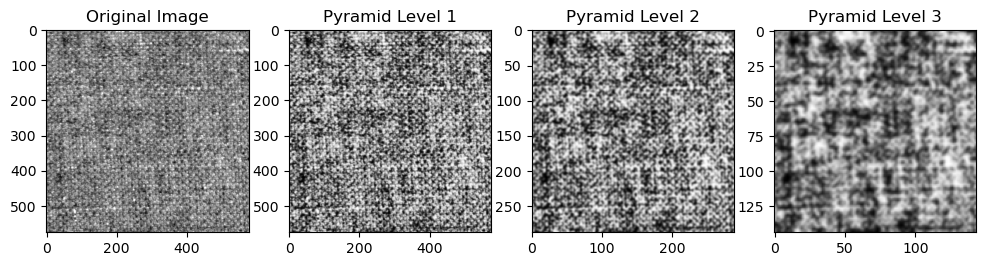

In [1282]:
Polt_image_Ex(first_row)

# apply  Sobel Filter

# Extract Features Function

In [1283]:
def sobel_filter(image):
    return filters.sobel(image)

In [1284]:
def histogram(sobel_images):
    hist, _ = np.histogram(sobel_images, bins=256)
    return hist

In [1285]:
All_Data["sobel_images_1"]=All_Data.pyramid_Level_1.apply(sobel_filter)
All_Data["sobel_images_2"]=All_Data.pyramid_Level_2.apply(sobel_filter)
All_Data["sobel_images_3"]=All_Data.pyramid_Level_3.apply(sobel_filter)

In [1286]:
All_Data.head()

,image_Path,Class,Original_image,pyramid_Level_1,pyramid_Level_2,pyramid_Level_3,sobel_images_1,sobel_images_2,sobel_images_3
0,textures/training\canvas1\canvas1-a-p001.png,canvas1,"[[73, 60, 63, 95, 68, 84, 119, 106, 81, 122, 1...","[[0.13066535878936186, 0.0909180908342738, 0.0...","[[0.043868798098362125, 0.061726925391758586, ...","[[0.16914288600018296, 0.34635513257281614, 0....","[[0.05151748872778214, 0.04645238342281721, 0....","[[0.03979903814089976, 0.09151397984012598, 0....","[[0.15750789027260834, 0.26315534540462104, 0...."
1,textures/training\canvas1\canvas1-a-p002.png,canvas1,"[[172, 154, 185, 197, 190, 137, 106, 91, 45, 4...","[[0.7562935110759926, 0.782482626124771, 0.857...","[[0.7229100396116469, 0.7431448665305476, 0.62...","[[0.40959431325881257, 0.273330703771129, 0.16...","[[0.08338510610593955, 0.1041703571169022, 0.1...","[[0.1576042122665073, 0.14785449780018897, 0.2...","[[0.14918070091472238, 0.16083503227164656, 0...."
2,textures/training\canvas1\canvas1-a-p003.png,canvas1,"[[176, 174, 162, 160, 155, 125, 95, 97, 85, 10...","[[0.8479703806448439, 0.8579909084932151, 0.84...","[[0.8469433362549534, 0.791698323756892, 0.624...","[[0.6826465398276229, 0.5975766296290241, 0.57...","[[0.047347319595717516, 0.028295502646395968, ...","[[0.08217829463984805, 0.13878659980929625, 0....","[[0.12685923723247935, 0.09259392923643724, 0...."
3,textures/training\canvas1\canvas1-a-p004.png,canvas1,"[[136, 102, 106, 134, 127, 143, 209, 232, 239,...","[[0.5023734533709161, 0.43956682810092784, 0.4...","[[0.5365395068765051, 0.7009733624605401, 0.86...","[[0.771639250059652, 0.8379575891364518, 0.805...","[[0.03169315156420056, 0.036017282603316714, 0...","[[0.12036807654122292, 0.23273838767812127, 0....","[[0.09487887536664945, 0.07786032706555202, 0...."
4,textures/training\canvas1\canvas1-a-p005.png,canvas1,"[[77, 90, 120, 101, 92, 111, 139, 152, 133, 13...","[[0.16714410947758157, 0.28212614398331914, 0....","[[0.311052809628826, 0.41942815924324783, 0.51...","[[0.3311208496176114, 0.3188630669080593, 0.25...","[[0.09509151132430581, 0.17797146064192107, 0....","[[0.07992283612909425, 0.12989133782886958, 0....","[[0.013944723541866488, 0.06148633901496523, 0..."


# Split all Data into traain and validation set

In [1287]:
train_data, val_data = train_test_split(All_Data, test_size=0.2, random_state=42, stratify=All_Data.Class)

# Apply histogram on train data

In [1288]:
train_data["histogram_Level_1"]=train_data.sobel_images_1.apply(histogram)
train_data["histogram_Level_2"]=train_data.sobel_images_2.apply(histogram)
train_data["histogram_Level_3"]=train_data.sobel_images_3.apply(histogram)

# Apply histogram on Validation data

In [1289]:
val_data["histogram_Level_1"]=val_data.sobel_images_1.apply(histogram)
val_data["histogram_Level_2"]=val_data.sobel_images_2.apply(histogram)
val_data["histogram_Level_3"]=val_data.sobel_images_3.apply(histogram)

In [1290]:
train_data.head()

,image_Path,Class,Original_image,pyramid_Level_1,pyramid_Level_2,pyramid_Level_3,sobel_images_1,sobel_images_2,sobel_images_3,histogram_Level_1,histogram_Level_2,histogram_Level_3
11,textures/training\canvas1\canvas1-a-p012.png,canvas1,"[[150, 116, 110, 129, 122, 88, 80, 101, 73, 99...","[[0.6377505617372079, 0.48549065405142416, 0.3...","[[0.4767728947877845, 0.3054775143998181, 0.17...","[[0.2997032699748253, 0.21096472560531548, 0.2...","[[0.11201592131293545, 0.1851582227596332, 0.1...","[[0.12136659601494248, 0.21346570791426395, 0....","[[0.09611953750969594, 0.08090406031097216, 0....","[51, 142, 215, 310, 378, 460, 531, 638, 687, 7...","[18, 32, 45, 61, 66, 92, 115, 126, 149, 171, 1...","[8, 7, 20, 15, 28, 23, 29, 41, 35, 46, 47, 63,..."
63,textures/training\linsseeds1\linseeds1-a-p004.png,linsseeds1,"[[145, 172, 166, 150, 140, 131, 128, 125, 121,...","[[0.7141866414942721, 0.7611850825895105, 0.74...","[[0.7297771337507357, 0.6838227419312017, 0.62...","[[0.7058810389372494, 0.6991175330277908, 0.71...","[[0.030493618094124195, 0.01945740562646033, 0...","[[0.03583804489107292, 0.06686601314205723, 0....","[[0.004150420125177932, 0.016922940265609813, ...","[1415, 2580, 3324, 3995, 4744, 5208, 5413, 576...","[76, 185, 226, 285, 343, 379, 441, 485, 535, 5...","[15, 22, 16, 27, 37, 41, 37, 55, 59, 59, 60, 6..."
5,textures/training\canvas1\canvas1-a-p006.png,canvas1,"[[128, 96, 111, 109, 90, 107, 115, 136, 126, 1...","[[0.48990754662196484, 0.4303691456917557, 0.4...","[[0.529763310816934, 0.4375795283774016, 0.359...","[[0.5280219253172374, 0.49620721303133936, 0.5...","[[0.06351760512314919, 0.08622347248109224, 0....","[[0.11316874726046125, 0.15284987893160015, 0....","[[0.02861389572576271, 0.03960411246130153, 0....","[81, 174, 301, 366, 476, 533, 629, 740, 830, 8...","[10, 19, 51, 69, 67, 105, 107, 136, 151, 152, ...","[6, 9, 12, 25, 25, 21, 31, 49, 48, 39, 58, 64,..."
48,textures/training\cushion1\cushion1-a-p019.png,cushion1,"[[125, 120, 111, 107, 109, 105, 101, 95, 92, 9...","[[0.5439999778951157, 0.5026591590125811, 0.45...","[[0.48709103565728573, 0.4386096172441205, 0.3...","[[0.4554457449754585, 0.3894495260378352, 0.32...","[[0.029519489092431357, 0.06545494664311537, 0...","[[0.03233958097016699, 0.07527396021215707, 0....","[[0.07102483577821758, 0.10668054799260007, 0....","[876, 1278, 1631, 1964, 2187, 2470, 2683, 2870...","[58, 102, 133, 177, 208, 217, 235, 283, 309, 3...","[1, 5, 12, 10, 6, 16, 18, 27, 30, 26, 21, 29, ..."
53,textures/training\cushion1\cushion1-a-p024.png,cushion1,"[[140, 153, 173, 178, 189, 199, 193, 192, 199,...","[[0.7280893572831574, 0.7687721911330302, 0.81...","[[0.7768124443848171, 0.8263117629748108, 0.88...","[[0.833049341294764, 0.8790909600797754, 0.901...","[[0.027870531970952715, 0.0602188043985305, 0....","[[0.039828449545625776, 0.077154314941468, 0.0...","[[0.05085925581013383, 0.061940614167240095, 0...","[529, 977, 1211, 1418, 1485, 1723, 1698, 1829,...","[34, 69, 92, 120, 159, 146, 182, 206, 224, 266...","[4, 5, 9, 11, 12, 13, 12, 17, 18, 22, 27, 22, ..."


In [1291]:
val_data.head()

,image_Path,Class,Original_image,pyramid_Level_1,pyramid_Level_2,pyramid_Level_3,sobel_images_1,sobel_images_2,sobel_images_3,histogram_Level_1,histogram_Level_2,histogram_Level_3
45,textures/training\cushion1\cushion1-a-p016.png,cushion1,"[[96, 100, 102, 106, 110, 110, 117, 118, 117, ...","[[0.3249602775553293, 0.35113314572906473, 0.3...","[[0.4239896673872726, 0.433197852176392, 0.459...","[[0.489480860505145, 0.5596243867419096, 0.701...","[[0.05652184266191743, 0.058231145606053455, 0...","[[0.029528292051182722, 0.022061645001171925, ...","[[0.04628138699834248, 0.14259944750710882, 0....","[528, 960, 1158, 1301, 1554, 1538, 1637, 1825,...","[41, 64, 110, 127, 148, 146, 169, 198, 218, 23...","[4, 8, 11, 10, 8, 8, 12, 12, 9, 31, 20, 33, 23..."
110,textures/training\sand1\sand1-a-p021.png,sand1,"[[100, 97, 75, 73, 80, 87, 95, 98, 97, 112, 12...","[[0.24314594931609745, 0.19569681884978046, 0....","[[0.13924905748934044, 0.15940968894042046, 0....","[[0.27449680628911954, 0.4178859913894241, 0.5...","[[0.037928027470875654, 0.07281262548982224, 0...","[[0.03977636815540878, 0.09651417092368102, 0....","[[0.16514633705315493, 0.24098647120877398, 0....","[858, 1122, 1366, 1514, 1613, 1858, 1984, 2015...","[54, 70, 100, 130, 140, 160, 158, 187, 213, 25...","[5, 9, 14, 26, 16, 25, 24, 27, 30, 23, 34, 48,..."
168,textures/training\stone1\stone1-a-p019.png,stone1,"[[144, 134, 133, 134, 137, 126, 116, 118, 121,...","[[0.6601953066795374, 0.6223101792358687, 0.59...","[[0.660887730994564, 0.6147405761642726, 0.551...","[[0.5962416318567707, 0.5596670847037795, 0.45...","[[0.04236274276926812, 0.056205292365636955, 0...","[[0.046596095237050335, 0.06717871181419016, 0...","[[0.036379215725730815, 0.10125789076478083, 0...","[319, 767, 1092, 1380, 1665, 1836, 2018, 2093,...","[43, 81, 122, 161, 191, 234, 240, 284, 295, 33...","[5, 9, 12, 24, 24, 25, 37, 39, 44, 45, 51, 50,..."
55,textures/training\cushion1\cushion1-a-p026.png,cushion1,"[[98, 94, 92, 92, 93, 96, 104, 110, 115, 123, ...","[[0.3007647654347479, 0.2719158471087382, 0.24...","[[0.28461496048523827, 0.2754301028417716, 0.3...","[[0.35680325398076296, 0.44940339860487133, 0....","[[0.030789770695393636, 0.04515350416489702, 0...","[[0.02581836398535391, 0.033000556895991746, 0...","[[0.0814617075809364, 0.15204138498642136, 0.1...","[582, 1157, 1461, 1810, 2076, 2222, 2438, 2615...","[37, 96, 98, 131, 154, 203, 250, 266, 257, 314...","[1, 2, 6, 8, 9, 8, 11, 15, 19, 31, 32, 31, 43,..."
58,textures/training\cushion1\cushion1-a-p029.png,cushion1,"[[200, 201, 187, 185, 191, 189, 182, 163, 165,...","[[0.9424548916173925, 0.9288889360145874, 0.90...","[[0.93628839250799, 0.9116116321647663, 0.8729...","[[0.9064792503502261, 0.8430659317927877, 0.75...","[[0.010621509992383676, 0.024823753457746872, ...","[[0.017936688019431907, 0.046104357529850544, ...","[[0.0509692787611189, 0.11277242703381386, 0.1...","[530, 1052, 1424, 1723, 1865, 1967, 2252, 2400...","[33, 74, 111, 149, 153, 189, 229, 248, 287, 29...","[2, 8, 5, 11, 14, 16, 19, 25, 20, 25, 29, 25, ..."


In [1292]:
train_data.Class.value_counts()

Class
canvas1       24
linsseeds1    24
cushion1      24
seat2         24
stone1        24
sand1         24
Name: count, dtype: int64

In [1293]:
val_data.Class.value_counts()

Class
cushion1      6
sand1         6
stone1        6
seat2         6
linsseeds1    6
canvas1       6
Name: count, dtype: int64

# Work on Train Data

# 1.3 

## Learning-Free Classification [2.0]

### Use the histogram for the first pyramid level (with shape [1 × 256])

In [1294]:
train_data.histogram_Level_1

11     [51, 142, 215, 310, 378, 460, 531, 638, 687, 7...
63     [1415, 2580, 3324, 3995, 4744, 5208, 5413, 576...
5      [81, 174, 301, 366, 476, 533, 629, 740, 830, 8...
48     [876, 1278, 1631, 1964, 2187, 2470, 2683, 2870...
53     [529, 977, 1211, 1418, 1485, 1723, 1698, 1829,...
                             ...                        
37     [517, 979, 1190, 1345, 1471, 1633, 1754, 1777,...
109    [687, 1011, 1235, 1510, 1657, 1794, 1916, 2090...
34     [617, 1157, 1365, 1509, 1725, 1846, 1961, 2162...
133    [99, 229, 377, 530, 650, 790, 959, 1001, 1102,...
56     [797, 1208, 1592, 1944, 2159, 2250, 2455, 2582...
Name: histogram_Level_1, Length: 144, dtype: object

In [1295]:
def split_By_cat(column,Df,cat):
    new_df = pd.DataFrame(Df.loc[Df['Class'] == cat, column].values.tolist(), columns=range(256))

    return new_df

In [1296]:
canvas1_df=split_By_cat("histogram_Level_1",train_data,"canvas1")
cushion1_df = split_By_cat("histogram_Level_1", train_data, "cushion1")
linsseeds1_df = split_By_cat("histogram_Level_1", train_data, "linsseeds1")
sand1_df = split_By_cat("histogram_Level_1", train_data, "sand1")
seat2_df = split_By_cat("histogram_Level_1", train_data, "seat2")
stone1_df = split_By_cat("histogram_Level_1", train_data, "stone1")

In [1297]:
canvas1_df.head()


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,51,142,215,310,378,460,531,638,687,772,...,0,1,1,0,1,0,1,0,0,1
1,81,174,301,366,476,533,629,740,830,875,...,0,2,1,0,0,2,0,0,0,1
2,53,165,218,373,424,537,592,692,783,887,...,3,1,2,2,2,2,1,0,1,2
3,80,185,302,393,475,573,641,740,747,898,...,0,2,0,1,0,0,0,0,0,1
4,44,134,213,318,366,440,560,583,682,723,...,1,0,1,1,0,0,3,0,1,1


In [1298]:
type(canvas1_df)

pandas.core.frame.DataFrame

In [1299]:
def avg(data):
    df_avg = data.mean()
    return df_avg

In [1300]:
canvas1_df_avg=avg(canvas1_df)
cushion1_df_avg=avg(cushion1_df)
linsseeds1_df_avg=avg(linsseeds1_df)
sand1_df_avg=avg(sand1_df)
seat2_df_avg=avg(seat2_df)
stone1_df_avg=avg(stone1_df)

In [1301]:
canvas1_df_avg

0       61.000000
1      154.250000
2      246.583333
3      339.833333
4      424.708333
          ...    
251      0.625000
252      0.791667
253      0.541667
254      0.416667
255      1.125000
Length: 256, dtype: float64

In [1302]:
type(canvas1_df_avg)

pandas.core.series.Series

In [1303]:
concatenated_df = pd.concat([canvas1_df_avg, cushion1_df_avg,linsseeds1_df_avg,sand1_df_avg,seat2_df_avg,stone1_df_avg], axis=1)

In [1304]:
column_names = ['canvas1', 'cushion1','linsseeds1','sand1','seat2','stone1']

# Assign the column names to the DataFrame
concatenated_df.columns = column_names


In [1305]:
concatenated_df

,canvas1,cushion1,linsseeds1,sand1,seat2,stone1
0,61.000000,613.250000,1249.541667,825.541667,78.291667,419.166667
1,154.250000,1076.958333,2509.041667,1251.041667,204.166667,889.708333
2,246.583333,1386.333333,3345.500000,1487.208333,330.125000,1212.625000
3,339.833333,1604.708333,4066.125000,1702.458333,457.208333,1489.666667
4,424.708333,1785.125000,4646.625000,1859.833333,568.250000,1715.083333
...,...,...,...,...,...,...
251,0.625000,0.458333,1.958333,0.833333,0.375000,0.666667
252,0.791667,0.416667,1.416667,0.708333,0.541667,0.625000
253,0.541667,0.625000,0.958333,0.875000,0.208333,0.625000
254,0.416667,0.333333,0.708333,0.333333,0.166667,0.541667


In [1306]:
concatenated_df.describe()

,canvas1,cushion1,linsseeds1,sand1,seat2,stone1
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000
std,1058.580435,1366.418937,1746.568506,1236.470945,1196.843258,1330.299110
min,0.416667,0.333333,0.708333,0.333333,0.166667,0.541667
25%,189.312500,61.260417,90.489583,93.333333,89.958333,82.645833
50%,1193.562500,651.562500,473.979167,882.041667,982.187500,720.645833
75%,2361.468750,2560.906250,1763.937500,2509.937500,2506.645833,2527.739583
max,2893.083333,3832.333333,6310.541667,3392.125000,3207.458333,3705.583333


### Visualization the six histograms for each category

In [1307]:
def Plot_Six_hist(data):
    i=0
    colors = plt.cm.tab10(np.arange(7))
    plt.figure(figsize=(10, 6))
    for label, series in data.items():
        plt.plot(series, label=label, color=colors[i], linewidth=2)
        plt.fill_between(np.arange(256), series, alpha=0.4, color=colors[i])
        i+=1

    plt.title('Mean Histogram of Each Class')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend(loc='best', prop={'size': 10})
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

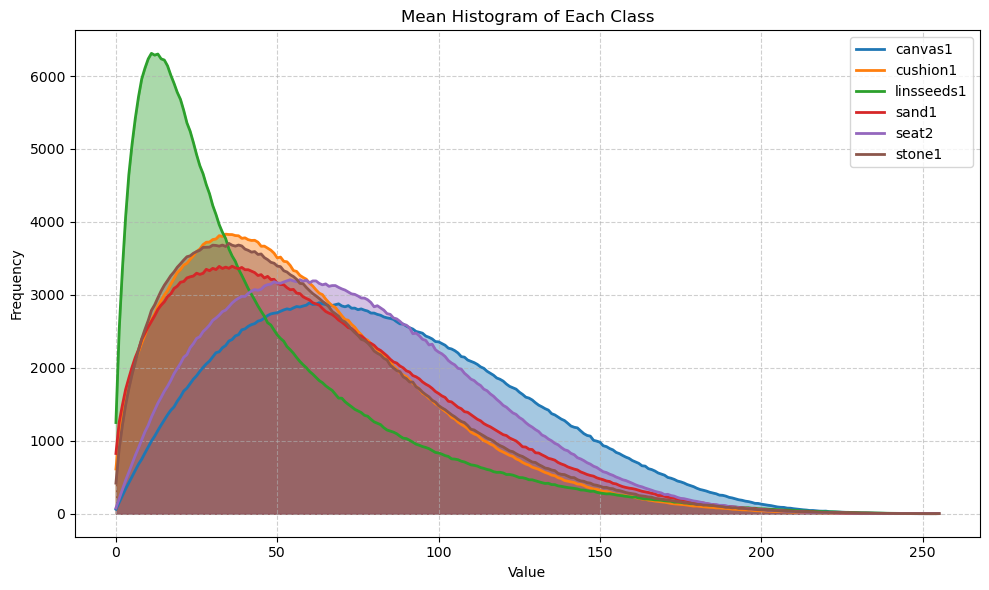

In [1308]:
data = {'canvas1': canvas1_df_avg, 'cushion1': cushion1_df_avg, 'linsseeds1': linsseeds1_df_avg, 'sand1': sand1_df_avg, 'seat2': seat2_df_avg, 'stone1': stone1_df_avg}
Plot_Six_hist(data)

## work on Validation data

In [1309]:
val_data.head()

,image_Path,Class,Original_image,pyramid_Level_1,pyramid_Level_2,pyramid_Level_3,sobel_images_1,sobel_images_2,sobel_images_3,histogram_Level_1,histogram_Level_2,histogram_Level_3
45,textures/training\cushion1\cushion1-a-p016.png,cushion1,"[[96, 100, 102, 106, 110, 110, 117, 118, 117, ...","[[0.3249602775553293, 0.35113314572906473, 0.3...","[[0.4239896673872726, 0.433197852176392, 0.459...","[[0.489480860505145, 0.5596243867419096, 0.701...","[[0.05652184266191743, 0.058231145606053455, 0...","[[0.029528292051182722, 0.022061645001171925, ...","[[0.04628138699834248, 0.14259944750710882, 0....","[528, 960, 1158, 1301, 1554, 1538, 1637, 1825,...","[41, 64, 110, 127, 148, 146, 169, 198, 218, 23...","[4, 8, 11, 10, 8, 8, 12, 12, 9, 31, 20, 33, 23..."
110,textures/training\sand1\sand1-a-p021.png,sand1,"[[100, 97, 75, 73, 80, 87, 95, 98, 97, 112, 12...","[[0.24314594931609745, 0.19569681884978046, 0....","[[0.13924905748934044, 0.15940968894042046, 0....","[[0.27449680628911954, 0.4178859913894241, 0.5...","[[0.037928027470875654, 0.07281262548982224, 0...","[[0.03977636815540878, 0.09651417092368102, 0....","[[0.16514633705315493, 0.24098647120877398, 0....","[858, 1122, 1366, 1514, 1613, 1858, 1984, 2015...","[54, 70, 100, 130, 140, 160, 158, 187, 213, 25...","[5, 9, 14, 26, 16, 25, 24, 27, 30, 23, 34, 48,..."
168,textures/training\stone1\stone1-a-p019.png,stone1,"[[144, 134, 133, 134, 137, 126, 116, 118, 121,...","[[0.6601953066795374, 0.6223101792358687, 0.59...","[[0.660887730994564, 0.6147405761642726, 0.551...","[[0.5962416318567707, 0.5596670847037795, 0.45...","[[0.04236274276926812, 0.056205292365636955, 0...","[[0.046596095237050335, 0.06717871181419016, 0...","[[0.036379215725730815, 0.10125789076478083, 0...","[319, 767, 1092, 1380, 1665, 1836, 2018, 2093,...","[43, 81, 122, 161, 191, 234, 240, 284, 295, 33...","[5, 9, 12, 24, 24, 25, 37, 39, 44, 45, 51, 50,..."
55,textures/training\cushion1\cushion1-a-p026.png,cushion1,"[[98, 94, 92, 92, 93, 96, 104, 110, 115, 123, ...","[[0.3007647654347479, 0.2719158471087382, 0.24...","[[0.28461496048523827, 0.2754301028417716, 0.3...","[[0.35680325398076296, 0.44940339860487133, 0....","[[0.030789770695393636, 0.04515350416489702, 0...","[[0.02581836398535391, 0.033000556895991746, 0...","[[0.0814617075809364, 0.15204138498642136, 0.1...","[582, 1157, 1461, 1810, 2076, 2222, 2438, 2615...","[37, 96, 98, 131, 154, 203, 250, 266, 257, 314...","[1, 2, 6, 8, 9, 8, 11, 15, 19, 31, 32, 31, 43,..."
58,textures/training\cushion1\cushion1-a-p029.png,cushion1,"[[200, 201, 187, 185, 191, 189, 182, 163, 165,...","[[0.9424548916173925, 0.9288889360145874, 0.90...","[[0.93628839250799, 0.9116116321647663, 0.8729...","[[0.9064792503502261, 0.8430659317927877, 0.75...","[[0.010621509992383676, 0.024823753457746872, ...","[[0.017936688019431907, 0.046104357529850544, ...","[[0.0509692787611189, 0.11277242703381386, 0.1...","[530, 1052, 1424, 1723, 1865, 1967, 2252, 2400...","[33, 74, 111, 149, 153, 189, 229, 248, 287, 29...","[2, 8, 5, 11, 14, 16, 19, 25, 20, 25, 29, 25, ..."


### Define list of histogram for each class.

In [1310]:
class_histograms=[]
for col in concatenated_df.columns:
     class_histograms.append(concatenated_df[col].tolist())

In [1311]:
concatenated_df

,canvas1,cushion1,linsseeds1,sand1,seat2,stone1
0,61.000000,613.250000,1249.541667,825.541667,78.291667,419.166667
1,154.250000,1076.958333,2509.041667,1251.041667,204.166667,889.708333
2,246.583333,1386.333333,3345.500000,1487.208333,330.125000,1212.625000
3,339.833333,1604.708333,4066.125000,1702.458333,457.208333,1489.666667
4,424.708333,1785.125000,4646.625000,1859.833333,568.250000,1715.083333
...,...,...,...,...,...,...
251,0.625000,0.458333,1.958333,0.833333,0.375000,0.666667
252,0.791667,0.416667,1.416667,0.708333,0.541667,0.625000
253,0.541667,0.625000,0.958333,0.875000,0.208333,0.625000
254,0.416667,0.333333,0.708333,0.333333,0.166667,0.541667


In [1312]:
val_data.head()

,image_Path,Class,Original_image,pyramid_Level_1,pyramid_Level_2,pyramid_Level_3,sobel_images_1,sobel_images_2,sobel_images_3,histogram_Level_1,histogram_Level_2,histogram_Level_3
45,textures/training\cushion1\cushion1-a-p016.png,cushion1,"[[96, 100, 102, 106, 110, 110, 117, 118, 117, ...","[[0.3249602775553293, 0.35113314572906473, 0.3...","[[0.4239896673872726, 0.433197852176392, 0.459...","[[0.489480860505145, 0.5596243867419096, 0.701...","[[0.05652184266191743, 0.058231145606053455, 0...","[[0.029528292051182722, 0.022061645001171925, ...","[[0.04628138699834248, 0.14259944750710882, 0....","[528, 960, 1158, 1301, 1554, 1538, 1637, 1825,...","[41, 64, 110, 127, 148, 146, 169, 198, 218, 23...","[4, 8, 11, 10, 8, 8, 12, 12, 9, 31, 20, 33, 23..."
110,textures/training\sand1\sand1-a-p021.png,sand1,"[[100, 97, 75, 73, 80, 87, 95, 98, 97, 112, 12...","[[0.24314594931609745, 0.19569681884978046, 0....","[[0.13924905748934044, 0.15940968894042046, 0....","[[0.27449680628911954, 0.4178859913894241, 0.5...","[[0.037928027470875654, 0.07281262548982224, 0...","[[0.03977636815540878, 0.09651417092368102, 0....","[[0.16514633705315493, 0.24098647120877398, 0....","[858, 1122, 1366, 1514, 1613, 1858, 1984, 2015...","[54, 70, 100, 130, 140, 160, 158, 187, 213, 25...","[5, 9, 14, 26, 16, 25, 24, 27, 30, 23, 34, 48,..."
168,textures/training\stone1\stone1-a-p019.png,stone1,"[[144, 134, 133, 134, 137, 126, 116, 118, 121,...","[[0.6601953066795374, 0.6223101792358687, 0.59...","[[0.660887730994564, 0.6147405761642726, 0.551...","[[0.5962416318567707, 0.5596670847037795, 0.45...","[[0.04236274276926812, 0.056205292365636955, 0...","[[0.046596095237050335, 0.06717871181419016, 0...","[[0.036379215725730815, 0.10125789076478083, 0...","[319, 767, 1092, 1380, 1665, 1836, 2018, 2093,...","[43, 81, 122, 161, 191, 234, 240, 284, 295, 33...","[5, 9, 12, 24, 24, 25, 37, 39, 44, 45, 51, 50,..."
55,textures/training\cushion1\cushion1-a-p026.png,cushion1,"[[98, 94, 92, 92, 93, 96, 104, 110, 115, 123, ...","[[0.3007647654347479, 0.2719158471087382, 0.24...","[[0.28461496048523827, 0.2754301028417716, 0.3...","[[0.35680325398076296, 0.44940339860487133, 0....","[[0.030789770695393636, 0.04515350416489702, 0...","[[0.02581836398535391, 0.033000556895991746, 0...","[[0.0814617075809364, 0.15204138498642136, 0.1...","[582, 1157, 1461, 1810, 2076, 2222, 2438, 2615...","[37, 96, 98, 131, 154, 203, 250, 266, 257, 314...","[1, 2, 6, 8, 9, 8, 11, 15, 19, 31, 32, 31, 43,..."
58,textures/training\cushion1\cushion1-a-p029.png,cushion1,"[[200, 201, 187, 185, 191, 189, 182, 163, 165,...","[[0.9424548916173925, 0.9288889360145874, 0.90...","[[0.93628839250799, 0.9116116321647663, 0.8729...","[[0.9064792503502261, 0.8430659317927877, 0.75...","[[0.010621509992383676, 0.024823753457746872, ...","[[0.017936688019431907, 0.046104357529850544, ...","[[0.0509692787611189, 0.11277242703381386, 0.1...","[530, 1052, 1424, 1723, 1865, 1967, 2252, 2400...","[33, 74, 111, 149, 153, 189, 229, 248, 287, 29...","[2, 8, 5, 11, 14, 16, 19, 25, 20, 25, 29, 25, ..."


### function to measure the distance between a given image histogram and the histogram for each class.
### using euclidean_distances

In [1313]:
unique_classes=['canvas1','cushion1','linsseeds1','sand1','seat2','stone1']

In [1314]:
def euclidean_distance(df, hist2):
    prediction = []
    min_distance = float('inf')
    predicted_class = None

    for i in range(6):
        euclidean = np.sqrt(np.sum((df- hist2[i])**2))

        if euclidean < min_distance:
            min_distance = euclidean
            predicted_class = unique_classes[i]
            
    # prediction.append(predicted_class)
    prediction=predicted_class

    return prediction

### Function to Compute the chi-square distance between the image histogram and each category histogram  
### using chi_square_distance

In [1315]:
dict_data = concatenated_df.to_dict(orient='list')

In [1316]:
def chi_square_distance(hist1, hist2):
    return 0.5 * np.sum(((hist1 - hist2) ** 2) / (hist1 + hist2 + 1e-10))

def classify_image_histogram_chi2(hist_image, average_histograms):
    distances = {category: chi_square_distance(hist_image, histogram) for category, histogram in average_histograms.items()}

    return min(distances, key=distances.get)



In [1317]:
def calculate_distance_each_image(images,class_histograms,Measure_Fun):
    predict_label=[]
    
    for Row in images:
        if (Measure_Fun=="chi"):
            predict_label.append(classify_image_histogram_chi2(Row,class_histograms))
        if(Measure_Fun=="euclidean"):
            predict_label.append(euclidean_distance(Row,class_histograms))

    return predict_label

In [1318]:
predict_label_euclidena_val=calculate_distance_each_image(val_data.histogram_Level_1,class_histograms,"euclidean")

In [1319]:
predict_label_chi_val=calculate_distance_each_image(val_data.histogram_Level_1,dict_data,"chi")

### Store the previous accuracy To compare All levels in the end

In [1320]:
accuracy_train_euclidena={}
accuracy_Valid_euclidena={}
accuracy_Test_euclidena={}


accuracy_Valid_Chi={}
accuracy_Train_Chi={}
accuracy_Test_Chi={}

### Evaluatation on validation (chi-square ,euclidean distances)

In [1321]:
accuracy_euclidena_val = accuracy_score(val_data.Class, predict_label_euclidena_val)
recall_euclidena = recall_score(val_data.Class, predict_label_euclidena_val, average='weighted')
precision_euclidena = precision_score(val_data.Class, predict_label_euclidena_val, average='weighted')

print(f"Accuracy: {accuracy_euclidena_val:.2f}")
print(f"Recall: {recall_euclidena:.2f}")
print(f"Precision: {precision_euclidena:.2f}")

Accuracy: 0.89
Recall: 0.89
Precision: 0.90


In [1322]:
accuracy_chi_val = accuracy_score(val_data.Class, predict_label_chi_val)
recall_chi = recall_score(val_data.Class, predict_label_chi_val, average='weighted')
precision_chi = precision_score(val_data.Class, predict_label_chi_val, average='weighted')

print(f"Accuracy: {accuracy_chi_val:.2f}")
print(f"Recall: {recall_chi:.2f}")
print(f"Precision: {precision_chi:.2f}")


Accuracy: 0.89
Recall: 0.89
Precision: 0.89


In [1323]:
accuracy_Valid_euclidena["Level_1"]=accuracy_euclidena_val
accuracy_Valid_Chi["Level_1"]=accuracy_chi_val



### Evaluatation on Train (chi-square ,euclidean distances)

In [1324]:
predict_label_euclidena_train=calculate_distance_each_image(train_data.histogram_Level_1,class_histograms,"euclidean")

In [1325]:
predict_label_chi_train = calculate_distance_each_image(train_data.histogram_Level_1, dict_data, "chi")

In [1326]:
accuracy_euclidena_train = accuracy_score(train_data.Class, predict_label_euclidena_train)
recall_euclidena = recall_score(train_data.Class, predict_label_euclidena_train, average='weighted')
precision_euclidena = precision_score(train_data.Class, predict_label_euclidena_train, average='weighted')

print(f"Accuracy: {accuracy_euclidena_train:.2f}")
print(f"Recall: {recall_euclidena:.2f}")
print(f"Precision: {precision_euclidena:.2f}")

Accuracy: 0.90
Recall: 0.90
Precision: 0.92


In [1327]:
accuracy_chi_train = accuracy_score(train_data.Class, predict_label_chi_train)
recall_chi = recall_score(train_data.Class, predict_label_chi_train, average='weighted')
precision_chi = precision_score(train_data.Class, predict_label_chi_train, average='weighted')

print(f"Accuracy: {accuracy_chi_train:.2f}")
print(f"Recall: {recall_chi:.2f}")
print(f"Precision: {precision_chi:.2f}")


Accuracy: 0.88
Recall: 0.88
Precision: 0.88


In [1328]:

accuracy_train_euclidena["Level_1"]=accuracy_euclidena_train
accuracy_Train_Chi["Level_1"]=accuracy_chi_train

### Check the miss-classified

In [1329]:
def miss_classified(Data_frame,Predictions,Level):
    misclassified_indices = [i for i in range(len(Data_frame.Class)) if Predictions[i] != Data_frame.Class.iloc[i]] 
    # random_number = random.randint(0, len(misclassified_indices) - 1)
    misclassified_image = Data_frame[Level].iloc[misclassified_indices[1]]
    true_label = Data_frame.Class.iloc[misclassified_indices[1]]
    false_label = Predictions[misclassified_indices[1]]
    return misclassified_indices,misclassified_image,true_label,false_label

### Function plot_Miss_Classified to Plot for one of the miss-classified 

In [1330]:

def plot_Miss_Classified(true_label,false_label,misclassified_image,title):
    data = {'canvas1': canvas1_df_avg, 'cushion1': cushion1_df_avg, 'linsseeds1': linsseeds1_df_avg, 'sand1': sand1_df_avg, 'seat2': seat2_df_avg, 'stone1': stone1_df_avg, 
            'misclassified': misclassified_image}

    # get the data of the true label and the false label
    data = {key: data[key] for key in [true_label, false_label, 'misclassified']}

    i = 0
    colors = plt.cm.tab10(np.arange(10))
    true_label_legend = f'True Label: {true_label}'
    false_label_legend = f'False Label: {false_label}'

    plt.figure(figsize=(10, 6))
    for label, series in data.items():
        if label == true_label:
            plt.plot(series, label=true_label_legend, color=colors[i], linewidth=2)
        elif label == false_label:
            plt.plot(series, label=false_label_legend, color=colors[i], linewidth=2)
        else:
            plt.plot(series, label=label, color=colors[i], linewidth=2)
        plt.fill_between(np.arange(256), series, alpha=0.4, color=colors[i])
        i += 1

    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f"{title}")
    plt.legend()
    plt.show()


In [1331]:
misclassified_indices_TE,misclassified_image_TE,true_label_TE,false_label_TE=miss_classified(train_data,predict_label_euclidena_train,"histogram_Level_1")

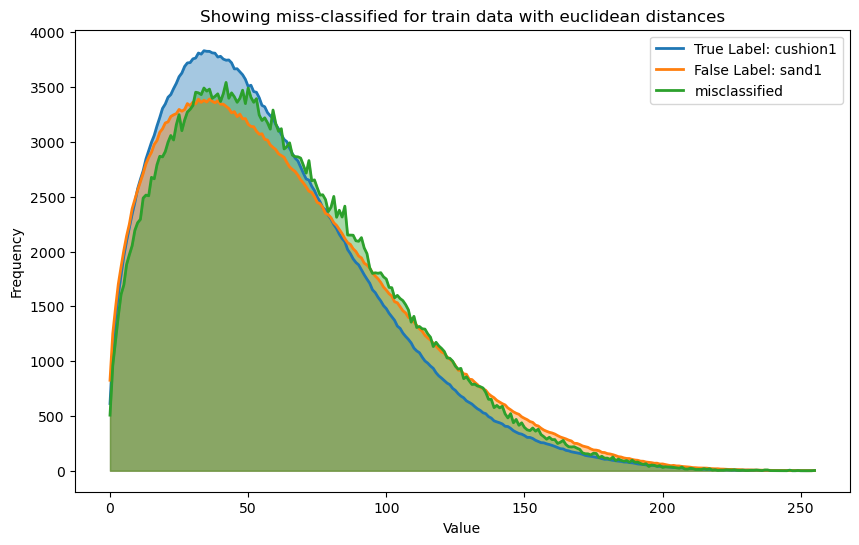

In [1332]:
plot_Miss_Classified(true_label_TE,false_label_TE,misclassified_image_TE,"Showing miss-classified for train data with euclidean distances")

In [1333]:
misclassified_indices_TC,misclassified_image_TC,true_label_TC,false_label_TC=miss_classified(train_data,predict_label_chi_train,"histogram_Level_1")

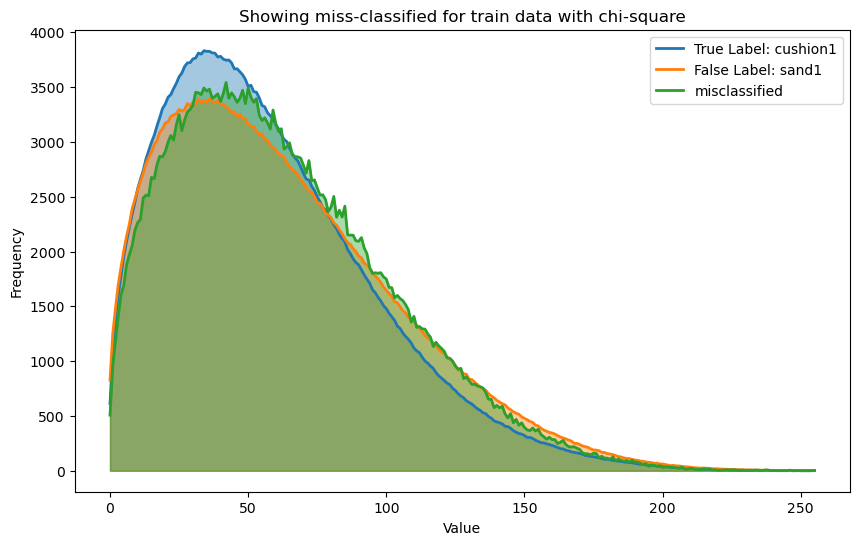

In [1334]:
plot_Miss_Classified(true_label_TC,false_label_TC,misclassified_image_TC,"Showing miss-classified for train data with chi-square")

In [1335]:
misclassified_indices_VE,misclassified_image_VE,true_label_VE,false_label_VE=miss_classified(val_data,predict_label_euclidena_val,"histogram_Level_1")

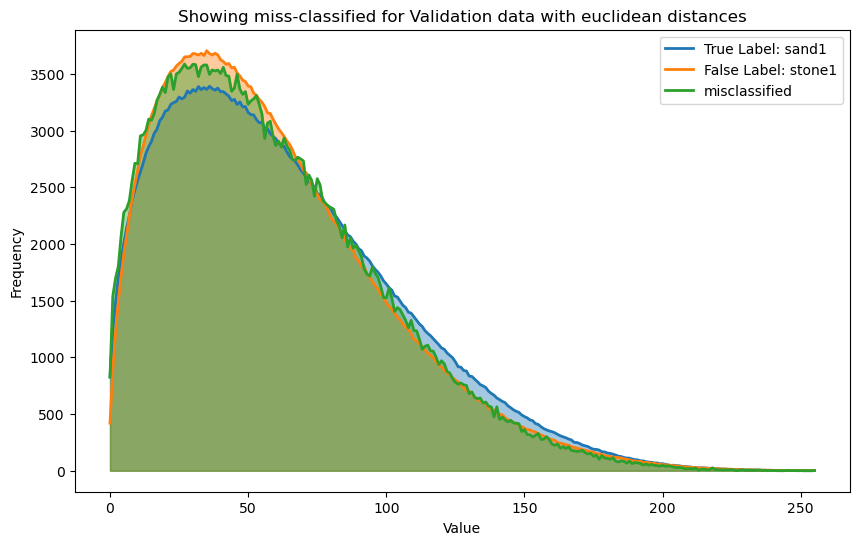

In [1336]:
plot_Miss_Classified(true_label_VE,false_label_VE,misclassified_image_VE,"Showing miss-classified for Validation data with euclidean distances")

In [1337]:
misclassified_indices,misclassified_image,true_label,false_label=miss_classified(val_data,predict_label_chi_val,"histogram_Level_1")

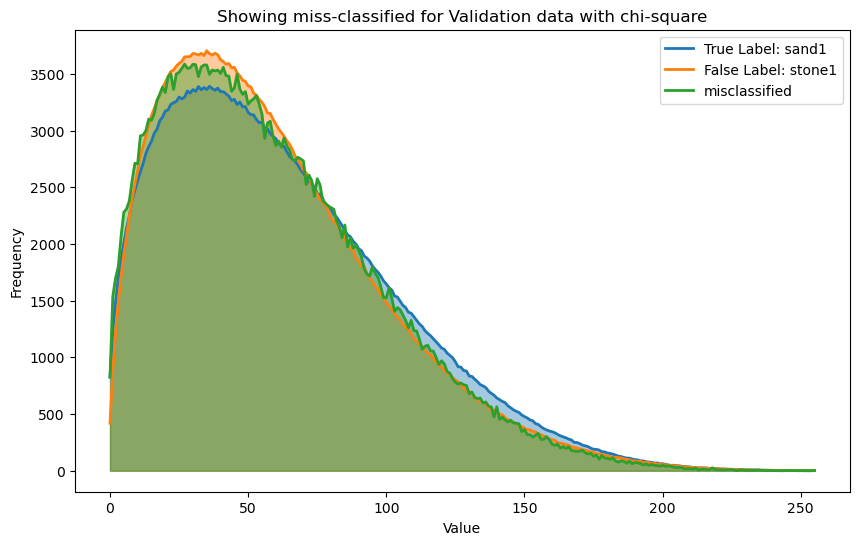

In [1338]:
plot_Miss_Classified(true_label,false_label,misclassified_image,"Showing miss-classified for Validation data with chi-square")

## Discussion 

### first I plot the average Histogram for each class then I use it to Visualize the miss classification clearfly we assign the image  base on the minimum distance between the image histogram and the average histogram and we see in all the previsoe Miss classifiction images the destance betweeen the image and the average of the false class less than the distance between the image and the average of the true class

# 1.4


## Learning-Based Classification

In [1339]:
def Flatten_histogram(row):
    histogram_1 = row['histogram_Level_1'].flatten()
    histogram_2 = row['histogram_Level_2'].flatten()
    histogram_3 = row['histogram_Level_3'].flatten()
    return np.concatenate([histogram_1, histogram_2, histogram_3])


In [1340]:
train_data['histogram_Level_1'].iloc[0].shape

(256,)

In [1341]:
train_data['histogram_Level_2'].iloc[0].shape

(256,)

In [1342]:
train_data['histogram_Level_3'].iloc[0].shape

(256,)

### flatten the validation data  feature from shape [3 × 256] to [1 × 768]

In [1343]:
train_data['Flattened_Column'] = train_data.apply(Flatten_histogram, axis=1)

In [1344]:
train_data.head()

,image_Path,Class,Original_image,pyramid_Level_1,pyramid_Level_2,pyramid_Level_3,sobel_images_1,sobel_images_2,sobel_images_3,histogram_Level_1,histogram_Level_2,histogram_Level_3,Flattened_Column
11,textures/training\canvas1\canvas1-a-p012.png,canvas1,"[[150, 116, 110, 129, 122, 88, 80, 101, 73, 99...","[[0.6377505617372079, 0.48549065405142416, 0.3...","[[0.4767728947877845, 0.3054775143998181, 0.17...","[[0.2997032699748253, 0.21096472560531548, 0.2...","[[0.11201592131293545, 0.1851582227596332, 0.1...","[[0.12136659601494248, 0.21346570791426395, 0....","[[0.09611953750969594, 0.08090406031097216, 0....","[51, 142, 215, 310, 378, 460, 531, 638, 687, 7...","[18, 32, 45, 61, 66, 92, 115, 126, 149, 171, 1...","[8, 7, 20, 15, 28, 23, 29, 41, 35, 46, 47, 63,...","[51, 142, 215, 310, 378, 460, 531, 638, 687, 7..."
63,textures/training\linsseeds1\linseeds1-a-p004.png,linsseeds1,"[[145, 172, 166, 150, 140, 131, 128, 125, 121,...","[[0.7141866414942721, 0.7611850825895105, 0.74...","[[0.7297771337507357, 0.6838227419312017, 0.62...","[[0.7058810389372494, 0.6991175330277908, 0.71...","[[0.030493618094124195, 0.01945740562646033, 0...","[[0.03583804489107292, 0.06686601314205723, 0....","[[0.004150420125177932, 0.016922940265609813, ...","[1415, 2580, 3324, 3995, 4744, 5208, 5413, 576...","[76, 185, 226, 285, 343, 379, 441, 485, 535, 5...","[15, 22, 16, 27, 37, 41, 37, 55, 59, 59, 60, 6...","[1415, 2580, 3324, 3995, 4744, 5208, 5413, 576..."
5,textures/training\canvas1\canvas1-a-p006.png,canvas1,"[[128, 96, 111, 109, 90, 107, 115, 136, 126, 1...","[[0.48990754662196484, 0.4303691456917557, 0.4...","[[0.529763310816934, 0.4375795283774016, 0.359...","[[0.5280219253172374, 0.49620721303133936, 0.5...","[[0.06351760512314919, 0.08622347248109224, 0....","[[0.11316874726046125, 0.15284987893160015, 0....","[[0.02861389572576271, 0.03960411246130153, 0....","[81, 174, 301, 366, 476, 533, 629, 740, 830, 8...","[10, 19, 51, 69, 67, 105, 107, 136, 151, 152, ...","[6, 9, 12, 25, 25, 21, 31, 49, 48, 39, 58, 64,...","[81, 174, 301, 366, 476, 533, 629, 740, 830, 8..."
48,textures/training\cushion1\cushion1-a-p019.png,cushion1,"[[125, 120, 111, 107, 109, 105, 101, 95, 92, 9...","[[0.5439999778951157, 0.5026591590125811, 0.45...","[[0.48709103565728573, 0.4386096172441205, 0.3...","[[0.4554457449754585, 0.3894495260378352, 0.32...","[[0.029519489092431357, 0.06545494664311537, 0...","[[0.03233958097016699, 0.07527396021215707, 0....","[[0.07102483577821758, 0.10668054799260007, 0....","[876, 1278, 1631, 1964, 2187, 2470, 2683, 2870...","[58, 102, 133, 177, 208, 217, 235, 283, 309, 3...","[1, 5, 12, 10, 6, 16, 18, 27, 30, 26, 21, 29, ...","[876, 1278, 1631, 1964, 2187, 2470, 2683, 2870..."
53,textures/training\cushion1\cushion1-a-p024.png,cushion1,"[[140, 153, 173, 178, 189, 199, 193, 192, 199,...","[[0.7280893572831574, 0.7687721911330302, 0.81...","[[0.7768124443848171, 0.8263117629748108, 0.88...","[[0.833049341294764, 0.8790909600797754, 0.901...","[[0.027870531970952715, 0.0602188043985305, 0....","[[0.039828449545625776, 0.077154314941468, 0.0...","[[0.05085925581013383, 0.061940614167240095, 0...","[529, 977, 1211, 1418, 1485, 1723, 1698, 1829,...","[34, 69, 92, 120, 159, 146, 182, 206, 224, 266...","[4, 5, 9, 11, 12, 13, 12, 17, 18, 22, 27, 22, ...","[529, 977, 1211, 1418, 1485, 1723, 1698, 1829,..."


In [1345]:
first_row = train_data.iloc[0]

In [1346]:
first_row.Flattened_Column.shape

(768,)

In [1347]:
first_row.Flattened_Column

array([  51,  142,  215,  310,  378,  460,  531,  638,  687,  772,  872,
        927, 1009, 1021, 1142, 1173, 1267, 1329, 1372, 1351, 1532, 1572,
       1637, 1783, 1695, 1830, 1893, 1898, 1897, 1973, 2018, 2167, 2110,
       2153, 2185, 2355, 2312, 2357, 2359, 2401, 2431, 2465, 2571, 2566,
       2616, 2594, 2567, 2634, 2695, 2662, 2656, 2652, 2755, 2783, 2656,
       2765, 2697, 2737, 2723, 2823, 2724, 2780, 2801, 2822, 2910, 2814,
       2808, 2780, 2839, 2859, 2784, 2828, 2745, 2744, 2777, 2718, 2714,
       2743, 2817, 2813, 2756, 2714, 2699, 2658, 2662, 2682, 2719, 2569,
       2595, 2565, 2584, 2595, 2565, 2598, 2513, 2560, 2425, 2505, 2374,
       2266, 2381, 2378, 2366, 2234, 2292, 2309, 2260, 2163, 2258, 2150,
       2172, 2111, 2127, 2011, 1989, 2023, 1950, 1947, 1958, 1896, 1820,
       1907, 1849, 1840, 1736, 1746, 1703, 1697, 1605, 1596, 1552, 1521,
       1454, 1504, 1471, 1452, 1332, 1389, 1288, 1331, 1289, 1239, 1212,
       1305, 1187, 1139, 1127, 1161, 1044, 1097, 10

### flatten the validation data  feature from shape [3 × 256] to [1 × 768]

In [1348]:
val_data['Flattened_Column'] = val_data.apply(Flatten_histogram, axis=1)

### Split data into featues and label

In [1349]:
x_train = np.stack(train_data['Flattened_Column'].to_numpy())
y_train = train_data['Class']

In [1350]:
x_Valid = np.stack(val_data['Flattened_Column'].to_numpy())
y_valid = val_data['Class']

In [1351]:
x_train.shape

(144, 768)

In [1352]:
x_Valid.shape

(36, 768)

In [1353]:
x_train

array([[  51,  142,  215, ...,    0,    1,    1],
       [1415, 2580, 3324, ...,    0,    3,    1],
       [  81,  174,  301, ...,    1,    0,    1],
       ...,
       [ 617, 1157, 1365, ...,    1,    2,    1],
       [  99,  229,  377, ...,    0,    0,    1],
       [ 797, 1208, 1592, ...,    0,    0,    1]], dtype=int64)

In [1354]:
y_train

11        canvas1
63     linsseeds1
5         canvas1
48       cushion1
53       cushion1
          ...    
37       cushion1
109         sand1
34       cushion1
133         seat2
56       cushion1
Name: Class, Length: 144, dtype: object

In [1355]:
x_train

array([[  51,  142,  215, ...,    0,    1,    1],
       [1415, 2580, 3324, ...,    0,    3,    1],
       [  81,  174,  301, ...,    1,    0,    1],
       ...,
       [ 617, 1157, 1365, ...,    1,    2,    1],
       [  99,  229,  377, ...,    0,    0,    1],
       [ 797, 1208, 1592, ...,    0,    0,    1]], dtype=int64)

### encode the class label before path to MLPClassifier

In [1356]:

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)


### Define the number of classes and the number of features

In [1357]:
num_classes = len(label_encoder.classes_)

input_dim=x_train.shape[1]

### Create and compile the MLP model

In [1458]:
tf.random.set_seed(42)
np.random.seed(42)
tf.config.experimental.enable_mlir_bridge()
tf.config.experimental.enable_tensor_float_32_execution(False)

model = keras.Sequential([
    layers.Input(shape=(input_dim,)), 
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


y_train_one_hot = keras.utils.to_categorical(y_train_encoded, num_classes)
y_valid_one_hot = keras.utils.to_categorical(y_valid_encoded, num_classes)


history = model.fit(x_train, y_train_one_hot, epochs=100, batch_size=32, validation_data=(x_Valid, y_valid_one_hot))

Epoch 1/100
5/5 [==============================] - 1s 50ms/step - loss: 1325.5060 - accuracy: 0.1736 - val_loss: 914.9800 - val_accuracy: 0.3333
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 575.8239 - accuracy: 0.3194 - val_loss: 354.8609 - val_accuracy: 0.4722
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 335.7006 - accuracy: 0.5556 - val_loss: 337.3780 - val_accuracy: 0.5000
Epoch 4/100
5/5 [==============================] - 0s 8ms/step - loss: 250.8188 - accuracy: 0.4861 - val_loss: 65.0549 - val_accuracy: 0.6667
Epoch 5/100
5/5 [==============================] - 0s 8ms/step - loss: 69.1301 - accuracy: 0.6597 - val_loss: 35.3996 - val_accuracy: 0.5556
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 35.8408 - accuracy: 0.7500 - val_loss: 31.8391 - val_accuracy: 0.6944
Epoch 7/100
5/5 [==============================] - 0s 9ms/step - loss: 17.0926 - accuracy: 0.8194 - val_loss: 23.1616 - val_accuracy: 0.7500
Epoc

### Evaluate the model on the training and validation sets

In [1459]:
y_train_pred = model.predict(x_train)
y_valid_pred = model.predict(x_Valid)

# Convert predictions to class labels
y_train_pred_labels = label_encoder.inverse_transform(y_train_pred.argmax(axis=1))
y_valid_pred_labels = label_encoder.inverse_transform(y_valid_pred.argmax(axis=1))

5/5 [==============================] - 0s 997us/step


2/2 [==============================] - 0s 4ms/step


### Calculate accuracy, precision, and recall on training set

In [1460]:

train_accuracy_MLP = accuracy_score(y_train, y_train_pred_labels)
train_precision = precision_score(y_train, y_train_pred_labels, average='weighted')
train_recall = recall_score(y_train, y_train_pred_labels, average='weighted')


print(f"Training Accuracy: {train_accuracy_MLP:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")

Training Accuracy: 1.0000
Training Precision: 1.0000
Training Recall: 1.0000


### Calculate accuracy, precision, and recall on validation set

In [1461]:

valid_accuracy_MLP = accuracy_score(y_valid, y_valid_pred_labels)
valid_precision = precision_score(y_valid, y_valid_pred_labels, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_labels, average='weighted')


print(f"Validation Accuracy: {valid_accuracy_MLP:.4f}")
print(f"Validation Precision: {valid_precision:.4f}")
print(f"Validation Recall: {valid_recall:.4f}")

Validation Accuracy: 1.0000
Validation Precision: 1.0000
Validation Recall: 1.0000


###  Plot training & validation accuracy values and loss

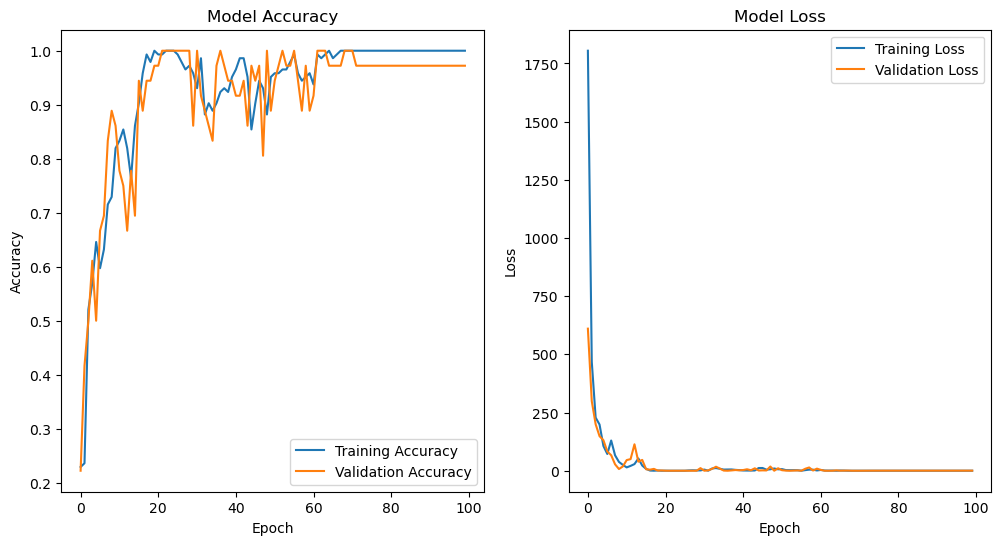

In [1362]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


# 1.5 

## Classification Comparison [1.0]

## Evaluate on Test Data

### Read test data 

In [1363]:
Testing_directory = 'textures/testing'

Test_Data=Create_DataFrame(Testing_directory)
Test_Data.head()

,image_Path,Class
0,textures/testing\canvas1\canvas1-a-p031.png,canvas1
1,textures/testing\canvas1\canvas1-a-p032.png,canvas1
2,textures/testing\canvas1\canvas1-a-p033.png,canvas1
3,textures/testing\canvas1\canvas1-a-p034.png,canvas1
4,textures/testing\canvas1\canvas1-a-p035.png,canvas1


In [1364]:
Test_Data.shape

(60, 2)

In [1365]:
pyramid_Level_1_test,pyramid_Level_2_test,pyramid_Level_3_test,Original_image_array_test=preprocess_single_image(Test_Data.image_Path)

### Add the 3 level in the Dataframe the Original_image (Test Data)

In [1366]:

Test_Data["Original_image"]=Original_image_array_test
Test_Data["pyramid_Level_1"]=pyramid_Level_1_test
Test_Data["pyramid_Level_2"]=pyramid_Level_2_test
Test_Data["pyramid_Level_3"]=pyramid_Level_3_test
Test_Data.head()

,image_Path,Class,Original_image,pyramid_Level_1,pyramid_Level_2,pyramid_Level_3
0,textures/testing\canvas1\canvas1-a-p031.png,canvas1,"[[166, 130, 152, 197, 155, 94, 108, 137, 159, ...","[[0.6960706310223387, 0.653946684109928, 0.717...","[[0.5941890688372418, 0.6043317994376094, 0.55...","[[0.33786057927700697, 0.2901814340582896, 0.2..."
1,textures/testing\canvas1\canvas1-a-p032.png,canvas1,"[[193, 153, 108, 95, 115, 173, 180, 182, 187, ...","[[0.833119007122836, 0.68066878757208, 0.48146...","[[0.7579243854381976, 0.6358794395535803, 0.61...","[[0.8005861465565522, 0.7496169688349333, 0.71..."
2,textures/testing\canvas1\canvas1-a-p033.png,canvas1,"[[157, 196, 249, 193, 113, 87, 104, 101, 101, ...","[[0.8707608113214972, 0.9289723612398872, 0.94...","[[0.9310671529614822, 0.8302439724709603, 0.60...","[[0.6168021151519028, 0.4352114982471549, 0.32..."
3,textures/testing\canvas1\canvas1-a-p034.png,canvas1,"[[102, 114, 151, 168, 151, 147, 156, 175, 163,...","[[0.29666388060084053, 0.4404413441136763, 0.6...","[[0.49102228109731194, 0.6815903456628517, 0.8...","[[0.6698612354991955, 0.7887542399403429, 0.90..."
4,textures/testing\canvas1\canvas1-a-p035.png,canvas1,"[[44, 84, 123, 133, 170, 175, 170, 163, 184, 1...","[[0.09620268608182016, 0.23468287477806388, 0....","[[0.318444944574658, 0.5433903866488452, 0.740...","[[0.4782270915338831, 0.47272821785909125, 0.3..."


### Visualize one example , Display the original image and the image pyramid (Test Data)

In [1367]:
first_row_test = Test_Data.iloc[0]
first_row_test

image_Path               textures/testing\canvas1\canvas1-a-p031.png
Class                                                        canvas1
Original_image     [[166, 130, 152, 197, 155, 94, 108, 137, 159, ...
pyramid_Level_1    [[0.6960706310223387, 0.653946684109928, 0.717...
pyramid_Level_2    [[0.5941890688372418, 0.6043317994376094, 0.55...
pyramid_Level_3    [[0.33786057927700697, 0.2901814340582896, 0.2...
Name: 0, dtype: object

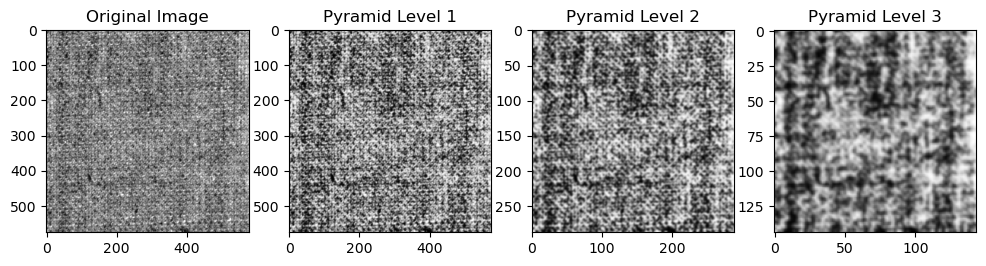

In [1368]:

Polt_image_Ex(first_row_test)

### Apply  Sobel Filter

In [1369]:
Test_Data["sobel_images_1"]=Test_Data.pyramid_Level_1.apply(sobel_filter)
Test_Data["sobel_images_2"]=Test_Data.pyramid_Level_2.apply(sobel_filter)
Test_Data["sobel_images_3"]=Test_Data.pyramid_Level_3.apply(sobel_filter)

In [1370]:
Test_Data.head()

,image_Path,Class,Original_image,pyramid_Level_1,pyramid_Level_2,pyramid_Level_3,sobel_images_1,sobel_images_2,sobel_images_3
0,textures/testing\canvas1\canvas1-a-p031.png,canvas1,"[[166, 130, 152, 197, 155, 94, 108, 137, 159, ...","[[0.6960706310223387, 0.653946684109928, 0.717...","[[0.5941890688372418, 0.6043317994376094, 0.55...","[[0.33786057927700697, 0.2901814340582896, 0.2...","[[0.08721371849823101, 0.07748555859156948, 0....","[[0.11805138483359405, 0.11624443855547503, 0....","[[0.07886043202158881, 0.04987925399648917, 0...."
1,textures/testing\canvas1\canvas1-a-p032.png,canvas1,"[[193, 153, 108, 95, 115, 173, 180, 182, 187, ...","[[0.833119007122836, 0.68066878757208, 0.48146...","[[0.7579243854381976, 0.6358794395535803, 0.61...","[[0.8005861465565522, 0.7496169688349333, 0.71...","[[0.10001059435686205, 0.23032527209973822, 0....","[[0.09493419619608807, 0.125105073078342, 0.05...","[[0.04502248043490727, 0.08288514043585662, 0...."
2,textures/testing\canvas1\canvas1-a-p033.png,canvas1,"[[157, 196, 249, 193, 113, 87, 104, 101, 101, ...","[[0.8707608113214972, 0.9289723612398872, 0.94...","[[0.9310671529614822, 0.8302439724709603, 0.60...","[[0.6168021151519028, 0.4352114982471549, 0.32...","[[0.04253298827326845, 0.050209202528403794, 0...","[[0.1043926475771907, 0.22554113992753447, 0.3...","[[0.17393280552436052, 0.16637049920446637, 0...."
3,textures/testing\canvas1\canvas1-a-p034.png,canvas1,"[[102, 114, 151, 168, 151, 147, 156, 175, 163,...","[[0.29666388060084053, 0.4404413441136763, 0.6...","[[0.49102228109731194, 0.6815903456628517, 0.8...","[[0.6698612354991955, 0.7887542399403429, 0.90...","[[0.10232925427919809, 0.25293724583471966, 0....","[[0.12634679730777776, 0.2100945648917741, 0.1...","[[0.16234897259962155, 0.21512660570812167, 0...."
4,textures/testing\canvas1\canvas1-a-p035.png,canvas1,"[[44, 84, 123, 133, 170, 175, 170, 163, 184, 1...","[[0.09620268608182016, 0.23468287477806388, 0....","[[0.318444944574658, 0.5433903866488452, 0.740...","[[0.4782270915338831, 0.47272821785909125, 0.3...","[[0.10857801551653827, 0.24358737744848122, 0....","[[0.14529955782298992, 0.26616864818143404, 0....","[[0.019760291679102204, 0.1107241423409345, 0...."


### Apply histogram on Test data


In [1371]:
Test_Data["histogram_Level_1"]=Test_Data.sobel_images_1.apply(histogram)
Test_Data["histogram_Level_2"]=Test_Data.sobel_images_2.apply(histogram)
Test_Data["histogram_Level_3"]=Test_Data.sobel_images_3.apply(histogram)

In [1372]:
Test_Data.head()

,image_Path,Class,Original_image,pyramid_Level_1,pyramid_Level_2,pyramid_Level_3,sobel_images_1,sobel_images_2,sobel_images_3,histogram_Level_1,histogram_Level_2,histogram_Level_3
0,textures/testing\canvas1\canvas1-a-p031.png,canvas1,"[[166, 130, 152, 197, 155, 94, 108, 137, 159, ...","[[0.6960706310223387, 0.653946684109928, 0.717...","[[0.5941890688372418, 0.6043317994376094, 0.55...","[[0.33786057927700697, 0.2901814340582896, 0.2...","[[0.08721371849823101, 0.07748555859156948, 0....","[[0.11805138483359405, 0.11624443855547503, 0....","[[0.07886043202158881, 0.04987925399648917, 0....","[88, 165, 261, 297, 474, 534, 578, 694, 763, 8...","[18, 36, 55, 76, 85, 111, 121, 132, 138, 183, ...","[7, 13, 16, 20, 30, 32, 41, 35, 45, 47, 61, 57..."
1,textures/testing\canvas1\canvas1-a-p032.png,canvas1,"[[193, 153, 108, 95, 115, 173, 180, 182, 187, ...","[[0.833119007122836, 0.68066878757208, 0.48146...","[[0.7579243854381976, 0.6358794395535803, 0.61...","[[0.8005861465565522, 0.7496169688349333, 0.71...","[[0.10001059435686205, 0.23032527209973822, 0....","[[0.09493419619608807, 0.125105073078342, 0.05...","[[0.04502248043490727, 0.08288514043585662, 0....","[75, 165, 272, 376, 468, 565, 657, 721, 845, 8...","[27, 31, 66, 66, 96, 109, 116, 133, 170, 173, ...","[4, 14, 21, 24, 28, 29, 35, 44, 45, 47, 63, 62..."
2,textures/testing\canvas1\canvas1-a-p033.png,canvas1,"[[157, 196, 249, 193, 113, 87, 104, 101, 101, ...","[[0.8707608113214972, 0.9289723612398872, 0.94...","[[0.9310671529614822, 0.8302439724709603, 0.60...","[[0.6168021151519028, 0.4352114982471549, 0.32...","[[0.04253298827326845, 0.050209202528403794, 0...","[[0.1043926475771907, 0.22554113992753447, 0.3...","[[0.17393280552436052, 0.16637049920446637, 0....","[65, 147, 227, 317, 422, 496, 584, 650, 735, 8...","[14, 25, 44, 61, 72, 97, 97, 105, 134, 161, 15...","[6, 11, 14, 18, 19, 41, 35, 45, 54, 48, 53, 60..."
3,textures/testing\canvas1\canvas1-a-p034.png,canvas1,"[[102, 114, 151, 168, 151, 147, 156, 175, 163,...","[[0.29666388060084053, 0.4404413441136763, 0.6...","[[0.49102228109731194, 0.6815903456628517, 0.8...","[[0.6698612354991955, 0.7887542399403429, 0.90...","[[0.10232925427919809, 0.25293724583471966, 0....","[[0.12634679730777776, 0.2100945648917741, 0.1...","[[0.16234897259962155, 0.21512660570812167, 0....","[47, 164, 226, 315, 411, 533, 605, 680, 771, 9...","[16, 22, 49, 66, 86, 73, 82, 112, 138, 128, 14...","[4, 7, 12, 21, 32, 23, 34, 31, 43, 58, 57, 65,..."
4,textures/testing\canvas1\canvas1-a-p035.png,canvas1,"[[44, 84, 123, 133, 170, 175, 170, 163, 184, 1...","[[0.09620268608182016, 0.23468287477806388, 0....","[[0.318444944574658, 0.5433903866488452, 0.740...","[[0.4782270915338831, 0.47272821785909125, 0.3...","[[0.10857801551653827, 0.24358737744848122, 0....","[[0.14529955782298992, 0.26616864818143404, 0....","[[0.019760291679102204, 0.1107241423409345, 0....","[55, 147, 244, 324, 412, 487, 552, 720, 745, 8...","[5, 16, 32, 46, 67, 74, 79, 103, 127, 119, 125...","[3, 7, 9, 26, 34, 29, 33, 37, 43, 48, 50, 64, ..."


### Evaluate Test on Learning  Free  Classification  (chi-square ,euclidean distances)    Level __1 

In [1373]:
predict_label_euclidena_Test=calculate_distance_each_image(Test_Data.histogram_Level_1,class_histograms,"euclidean")

In [1374]:
predict_label_chi_test=calculate_distance_each_image(Test_Data.histogram_Level_1,dict_data,"chi")

In [1375]:
accuracy_euclidena_tset = accuracy_score(Test_Data.Class, predict_label_euclidena_Test)
recall_euclidena_tset = recall_score(Test_Data.Class, predict_label_euclidena_Test, average='weighted')
precision_euclidena_tset = precision_score(Test_Data.Class, predict_label_euclidena_Test, average='weighted')

print(f"Accuracy: {accuracy_euclidena_tset:.2f}")
print(f"Recall: {recall_euclidena_tset:.2f}")
print(f"Precision: {precision_euclidena_tset:.2f}")

Accuracy: 0.85
Recall: 0.85
Precision: 0.85


In [1376]:
accuracy_chi_test = accuracy_score(Test_Data.Class, predict_label_chi_test)
recall_chi_test = recall_score(Test_Data.Class, predict_label_chi_test, average='weighted')
precision_chi_test = precision_score(Test_Data.Class, predict_label_chi_test, average='weighted')

print(f"Accuracy: {accuracy_chi_test:.2f}")
print(f"Recall: {recall_chi_test:.2f}")
print(f"Precision: {precision_chi_test:.2f}")


Accuracy: 0.82
Recall: 0.82
Precision: 0.83


### Store Accuracy for test with euclidena and Chi distance

In [1377]:
accuracy_Test_euclidena["Level_1"]=accuracy_euclidena_tset
accuracy_Test_Chi["Level_1"]=accuracy_chi_test

### Check the miss-classified for Test Data

In [1378]:
misclassified_indices_SE,misclassified_image_SE,true_label_SE,false_label_SE=miss_classified(Test_Data,predict_label_euclidena_Test,"histogram_Level_1")


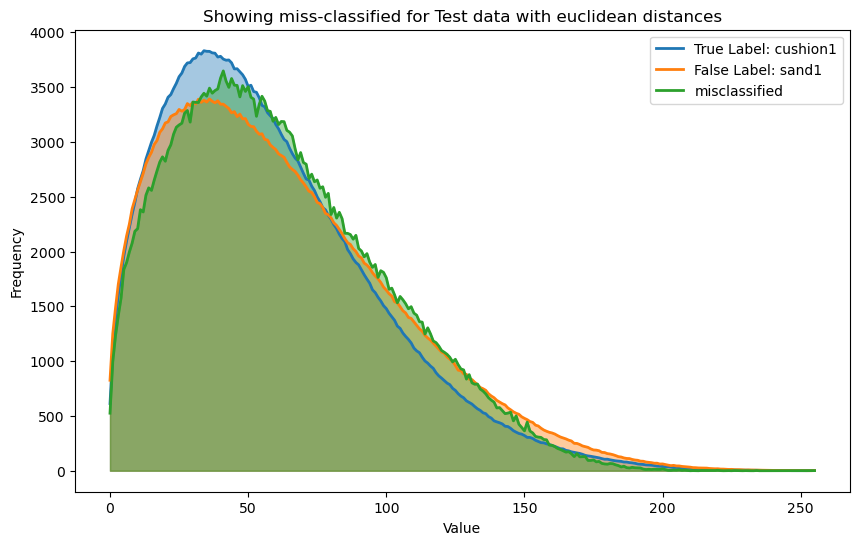

In [1379]:
plot_Miss_Classified(true_label_SE,false_label_SE,misclassified_image_SE,"Showing miss-classified for Test data with euclidean distances")

In [1380]:
misclassified_indices_SC,misclassified_image_SC,true_label_SC,false_label_SC=miss_classified(Test_Data,predict_label_chi_test,"histogram_Level_1")

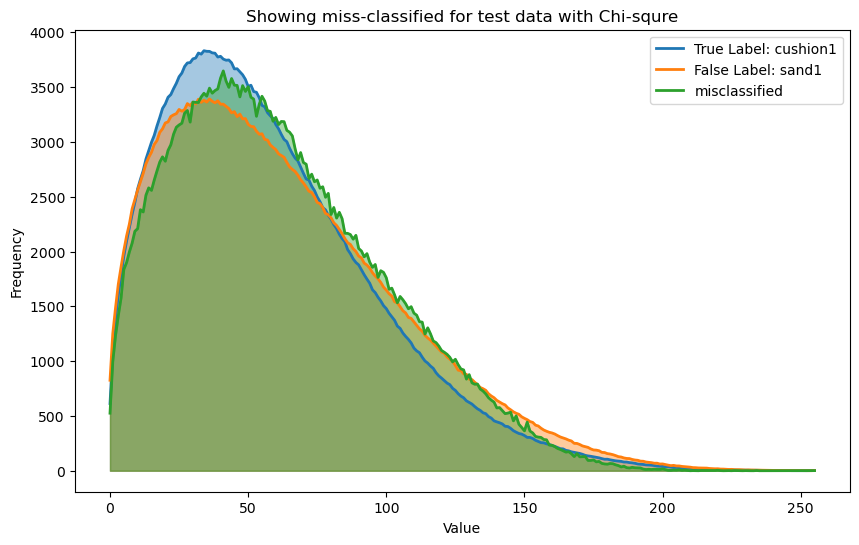

In [1381]:
plot_Miss_Classified(true_label_SC,false_label_SC,misclassified_image_SC,"Showing miss-classified for test data with Chi-squre")

## Apply   MLPClassifier (Test Data)

### flatten the Test data  feature from shape [3 × 256] to [1 × 768]

In [1382]:
Test_Data['Flattened_Column'] = Test_Data.apply(Flatten_histogram, axis=1)

In [1383]:
x_Test = np.stack(Test_Data['Flattened_Column'].to_numpy())
y_Test = Test_Data['Class']


In [1384]:
x_Test.shape

(60, 768)

### encode the label before path to MLPClassifier

In [1385]:
y_test_encoded = label_encoder.transform(y_Test)

### Evaluate the model on the testing sets


In [1462]:
y_test_pred = model.predict(x_Test)

y_test_pred_labels = label_encoder.inverse_transform(y_test_pred.argmax(axis=1))

2/2 [==============================] - 0s 2ms/step


### Calculate accuracy, precision, and recall on testing set

In [1463]:
test_accuracy_MLP = accuracy_score(y_Test, y_test_pred_labels)
test_precision = precision_score(y_Test, y_test_pred_labels, average='weighted')
test_recall = recall_score(y_Test, y_test_pred_labels, average='weighted')


print(f"Tset Accuracy: {test_accuracy_MLP:.4f}")
print(f"Tset Precision: {test_precision:.4f}")
print(f"Tset Recall: {test_recall:.4f}")

Tset Accuracy: 1.0000
Tset Precision: 1.0000
Tset Recall: 1.0000


## Discussion 

### The multi-layer perceptron model has strong performance on test data in contrast to the free-learning classification methods . The MLP achieved an accuracy of 100% on the test data while the Euclidean distance achieved an accuracy of 85% and the Chi-Squared distance achieved an accuracy of 82% .

### MLP excels in strong performance but demands substantial data and training effort. Learning-Free models are faster, simpler, and require less data, but may lack performance.The MLP also achieved a better generalization and robustness than the learning-free classification methods.

### the free-learning classification methods easy to understand where it just compare the image histogram with the average histogram of each category . 

# 1.6

## Improved Classification [1.0]


## The second level

In [1388]:
train_data.head()

,image_Path,Class,Original_image,pyramid_Level_1,pyramid_Level_2,pyramid_Level_3,sobel_images_1,sobel_images_2,sobel_images_3,histogram_Level_1,histogram_Level_2,histogram_Level_3,Flattened_Column
11,textures/training\canvas1\canvas1-a-p012.png,canvas1,"[[150, 116, 110, 129, 122, 88, 80, 101, 73, 99...","[[0.6377505617372079, 0.48549065405142416, 0.3...","[[0.4767728947877845, 0.3054775143998181, 0.17...","[[0.2997032699748253, 0.21096472560531548, 0.2...","[[0.11201592131293545, 0.1851582227596332, 0.1...","[[0.12136659601494248, 0.21346570791426395, 0....","[[0.09611953750969594, 0.08090406031097216, 0....","[51, 142, 215, 310, 378, 460, 531, 638, 687, 7...","[18, 32, 45, 61, 66, 92, 115, 126, 149, 171, 1...","[8, 7, 20, 15, 28, 23, 29, 41, 35, 46, 47, 63,...","[51, 142, 215, 310, 378, 460, 531, 638, 687, 7..."
63,textures/training\linsseeds1\linseeds1-a-p004.png,linsseeds1,"[[145, 172, 166, 150, 140, 131, 128, 125, 121,...","[[0.7141866414942721, 0.7611850825895105, 0.74...","[[0.7297771337507357, 0.6838227419312017, 0.62...","[[0.7058810389372494, 0.6991175330277908, 0.71...","[[0.030493618094124195, 0.01945740562646033, 0...","[[0.03583804489107292, 0.06686601314205723, 0....","[[0.004150420125177932, 0.016922940265609813, ...","[1415, 2580, 3324, 3995, 4744, 5208, 5413, 576...","[76, 185, 226, 285, 343, 379, 441, 485, 535, 5...","[15, 22, 16, 27, 37, 41, 37, 55, 59, 59, 60, 6...","[1415, 2580, 3324, 3995, 4744, 5208, 5413, 576..."
5,textures/training\canvas1\canvas1-a-p006.png,canvas1,"[[128, 96, 111, 109, 90, 107, 115, 136, 126, 1...","[[0.48990754662196484, 0.4303691456917557, 0.4...","[[0.529763310816934, 0.4375795283774016, 0.359...","[[0.5280219253172374, 0.49620721303133936, 0.5...","[[0.06351760512314919, 0.08622347248109224, 0....","[[0.11316874726046125, 0.15284987893160015, 0....","[[0.02861389572576271, 0.03960411246130153, 0....","[81, 174, 301, 366, 476, 533, 629, 740, 830, 8...","[10, 19, 51, 69, 67, 105, 107, 136, 151, 152, ...","[6, 9, 12, 25, 25, 21, 31, 49, 48, 39, 58, 64,...","[81, 174, 301, 366, 476, 533, 629, 740, 830, 8..."
48,textures/training\cushion1\cushion1-a-p019.png,cushion1,"[[125, 120, 111, 107, 109, 105, 101, 95, 92, 9...","[[0.5439999778951157, 0.5026591590125811, 0.45...","[[0.48709103565728573, 0.4386096172441205, 0.3...","[[0.4554457449754585, 0.3894495260378352, 0.32...","[[0.029519489092431357, 0.06545494664311537, 0...","[[0.03233958097016699, 0.07527396021215707, 0....","[[0.07102483577821758, 0.10668054799260007, 0....","[876, 1278, 1631, 1964, 2187, 2470, 2683, 2870...","[58, 102, 133, 177, 208, 217, 235, 283, 309, 3...","[1, 5, 12, 10, 6, 16, 18, 27, 30, 26, 21, 29, ...","[876, 1278, 1631, 1964, 2187, 2470, 2683, 2870..."
53,textures/training\cushion1\cushion1-a-p024.png,cushion1,"[[140, 153, 173, 178, 189, 199, 193, 192, 199,...","[[0.7280893572831574, 0.7687721911330302, 0.81...","[[0.7768124443848171, 0.8263117629748108, 0.88...","[[0.833049341294764, 0.8790909600797754, 0.901...","[[0.027870531970952715, 0.0602188043985305, 0....","[[0.039828449545625776, 0.077154314941468, 0.0...","[[0.05085925581013383, 0.061940614167240095, 0...","[529, 977, 1211, 1418, 1485, 1723, 1698, 1829,...","[34, 69, 92, 120, 159, 146, 182, 206, 224, 266...","[4, 5, 9, 11, 12, 13, 12, 17, 18, 22, 27, 22, ...","[529, 977, 1211, 1418, 1485, 1723, 1698, 1829,..."


In [1389]:
canvas1_df_2=split_By_cat("histogram_Level_2",train_data,"canvas1")
cushion1_df_2 = split_By_cat("histogram_Level_2", train_data, "cushion1")
linsseeds1_df_2 = split_By_cat("histogram_Level_2", train_data, "linsseeds1")
sand1_df_2 = split_By_cat("histogram_Level_2", train_data, "sand1")
seat2_df_2 = split_By_cat("histogram_Level_2", train_data, "seat2")
stone1_df_2 = split_By_cat("histogram_Level_2", train_data, "stone1")

In [1390]:
canvas1_df_avg_2=avg(canvas1_df_2)
cushion1_df_avg_2=avg(cushion1_df_2)
linsseeds1_df_avg_2=avg(linsseeds1_df_2)
sand1_df_avg_2=avg(sand1_df_2)
seat2_df_avg_2=avg(seat2_df_2)
stone1_df_avg_2=avg(stone1_df_2)

In [1391]:
concatenated_df_2 = pd.concat([canvas1_df_avg_2, cushion1_df_avg_2,linsseeds1_df_avg_2,sand1_df_avg_2,seat2_df_avg_2,stone1_df_avg_2], axis=1)

In [1392]:
column_names = ['canvas1', 'cushion1','linsseeds1','sand1','seat2','stone1']

# Assign the column names to the DataFrame
concatenated_df_2.columns = column_names

In [1393]:
concatenated_df_2

,canvas1,cushion1,linsseeds1,sand1,seat2,stone1
0,14.208333,41.041667,71.500000,39.416667,11.333333,39.708333
1,25.875000,78.000000,160.083333,74.750000,23.416667,80.333333
2,42.500000,111.708333,238.958333,107.458333,32.541667,124.041667
3,60.625000,138.333333,301.541667,132.125000,44.791667,159.291667
4,73.041667,171.125000,352.083333,155.625000,56.166667,195.916667
...,...,...,...,...,...,...
251,0.333333,1.083333,1.000000,0.791667,0.458333,0.625000
252,0.500000,0.541667,1.166667,0.708333,0.708333,0.583333
253,0.416667,0.750000,1.166667,0.583333,0.458333,0.666667
254,0.250000,0.833333,0.833333,0.291667,0.291667,0.541667


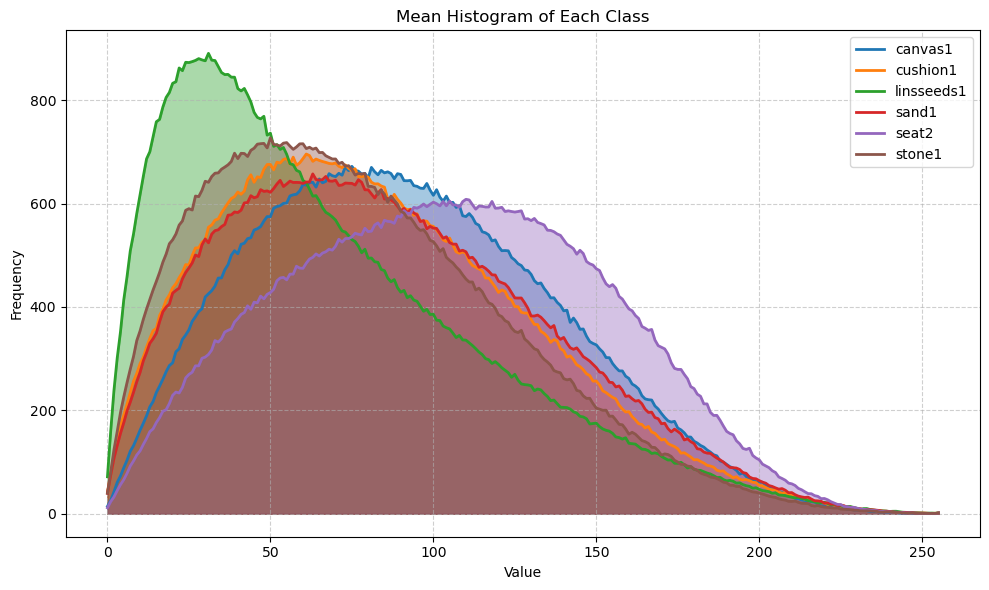

In [1394]:
data_level_2 = {'canvas1': canvas1_df_avg_2, 'cushion1': cushion1_df_avg_2, 'linsseeds1': linsseeds1_df_avg_2, 'sand1': sand1_df_avg_2, 'seat2': seat2_df_avg_2, 'stone1': stone1_df_avg_2}
Plot_Six_hist(data_level_2)

### work on Validation data Level 2

In [1395]:
class_histograms_2=[]
for col in concatenated_df_2.columns:
     class_histograms_2.append(concatenated_df_2[col].tolist())

In [1396]:
dict_data_2 = concatenated_df_2.to_dict(orient='list')

### Evaluatation on Validation (chi-square ,euclidean distances)    Level __2

In [1397]:
predict_label_euclidena_val_2=calculate_distance_each_image(val_data.histogram_Level_2,class_histograms_2,"euclidean")

In [1398]:
predict_label_chi_val_2=calculate_distance_each_image(val_data.histogram_Level_2,dict_data_2,"chi")

In [1399]:
accuracy_euclidena_val_2 = accuracy_score(val_data.Class, predict_label_euclidena_val_2)
recall_euclidena_2 = recall_score(val_data.Class, predict_label_euclidena_val_2, average='weighted')
precision_euclidena_2 = precision_score(val_data.Class, predict_label_euclidena_val_2, average='weighted')

print(f"Accuracy: {accuracy_euclidena_val_2:.2f}")
print(f"Recall: {recall_euclidena_2:.2f}")
print(f"Precision: {precision_euclidena_2:.2f}")

Accuracy: 0.83
Recall: 0.83
Precision: 0.82


In [1400]:
accuracy_chi_val_2 = accuracy_score(val_data.Class, predict_label_chi_val_2)
recall_chi_2 = recall_score(val_data.Class, predict_label_chi_val_2, average='weighted')
precision_chi_2 = precision_score(val_data.Class, predict_label_chi_val_2, average='weighted')

print(f"Accuracy: {accuracy_chi_val_2:.2f}")
print(f"Recall: {recall_chi_2:.2f}")
print(f"Precision: {precision_chi_2:.2f}")

Accuracy: 0.81
Recall: 0.81
Precision: 0.78


In [1401]:
accuracy_Valid_euclidena["Level_2"]=accuracy_euclidena_val_2
accuracy_Valid_Chi["Level_2"]=accuracy_chi_val_2

### Evaluatation on Train (chi-square ,euclidean distances)    Level __2

In [1402]:
predict_label_euclidena_train_2=calculate_distance_each_image(train_data.histogram_Level_2,class_histograms_2,"euclidean")

In [1403]:
predict_label_chi_train_2 = calculate_distance_each_image(train_data.histogram_Level_2, dict_data_2, "chi")

In [1404]:
accuracy_euclidena_train_2 = accuracy_score(train_data.Class, predict_label_euclidena_train_2)
recall_euclidena_2 = recall_score(train_data.Class, predict_label_euclidena_train_2, average='weighted')
precision_euclidena_2 = precision_score(train_data.Class, predict_label_euclidena_train_2, average='weighted')

print(f"Accuracy: {accuracy_euclidena_train_2:.2f}")
print(f"Recall: {recall_euclidena_2:.2f}")
print(f"Precision: {precision_euclidena_2:.2f}")

Accuracy: 0.84
Recall: 0.84
Precision: 0.82


In [1405]:
accuracy_chi_Train_2 = accuracy_score(train_data.Class, predict_label_chi_train_2)
recall_chi_2 = recall_score(train_data.Class, predict_label_chi_train_2, average='weighted')
precision_chi_2 = precision_score(train_data.Class, predict_label_chi_train_2, average='weighted')

print(f"Accuracy: {accuracy_chi_Train_2:.2f}")
print(f"Recall: {recall_chi_2:.2f}")
print(f"Precision: {precision_chi_2:.2f}")

Accuracy: 0.83
Recall: 0.83
Precision: 0.82


In [1406]:

accuracy_train_euclidena["Level_2"]=accuracy_euclidena_train_2
accuracy_Train_Chi["Level_2"]=accuracy_chi_Train_2



### Evaluatation On Test (chi-square ,euclidean distances)    Level __2

In [1407]:
predict_label_euclidena_Test_2=calculate_distance_each_image(Test_Data.histogram_Level_2,class_histograms_2,"euclidean")

In [1408]:
predict_label_chi_test_2=calculate_distance_each_image(Test_Data.histogram_Level_2,dict_data_2,"chi")

In [1409]:
accuracy_euclidena_tset_2 = accuracy_score(Test_Data.Class, predict_label_euclidena_Test_2)
recall_euclidena_tset_2 = recall_score(Test_Data.Class, predict_label_euclidena_Test_2, average='weighted')
precision_euclidena_tset_2 = precision_score(Test_Data.Class, predict_label_euclidena_Test_2, average='weighted')

print(f"Accuracy: {accuracy_euclidena_tset_2:.2f}")
print(f"Recall: {recall_euclidena_tset_2:.2f}")
print(f"Precision: {precision_euclidena_tset_2:.2f}")

Accuracy: 0.87
Recall: 0.87
Precision: 0.87


In [1410]:
accuracy_chi_test_2 = accuracy_score(Test_Data.Class, predict_label_chi_test_2)
recall_chi_test_2 = recall_score(Test_Data.Class, predict_label_chi_test_2, average='weighted')
precision_chi_test_2 = precision_score(Test_Data.Class, predict_label_chi_test_2, average='weighted')

print(f"Accuracy: {accuracy_chi_test_2:.2f}")
print(f"Recall: {recall_chi_test_2:.2f}")
print(f"Precision: {precision_chi_test_2:.2f}")

Accuracy: 0.85
Recall: 0.85
Precision: 0.86


In [1411]:

accuracy_Test_euclidena["Level_2"]=accuracy_euclidena_tset_2
accuracy_Test_Chi["Level_2"]=accuracy_chi_test_2

### Check the miss-classified   Level  --2

In [1412]:

def plot_Miss_Classified_2(true_label,false_label,misclassified_image,title):
    data = {'canvas1': canvas1_df_avg_2, 'cushion1': cushion1_df_avg_2, 'linsseeds1': linsseeds1_df_avg_2, 'sand1': sand1_df_avg_2, 'seat2': seat2_df_avg_2, 'stone1': stone1_df_avg_2, 
            'misclassified': misclassified_image}

    # get the data of the true label and the false label
    data = {key: data[key] for key in [true_label, false_label, 'misclassified']}

    i = 0
    colors = plt.cm.tab10(np.arange(10))
    true_label_legend = f'True Label: {true_label}'
    false_label_legend = f'False Label: {false_label}'

    plt.figure(figsize=(10, 6))
    for label, series in data.items():
        if label == true_label:
            plt.plot(series, label=true_label_legend, color=colors[i], linewidth=2)
        elif label == false_label:
            plt.plot(series, label=false_label_legend, color=colors[i], linewidth=2)
        else:
            plt.plot(series, label=label, color=colors[i], linewidth=2)
        plt.fill_between(np.arange(256), series, alpha=0.4, color=colors[i])
        i += 1

    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f"{title}")
    plt.legend()
    plt.show()


In [1413]:
misclassified_indices_TE_2,misclassified_image_TE_2,true_label_TE_2,false_label_TE_2=miss_classified(train_data,predict_label_euclidena_train_2,"histogram_Level_2")

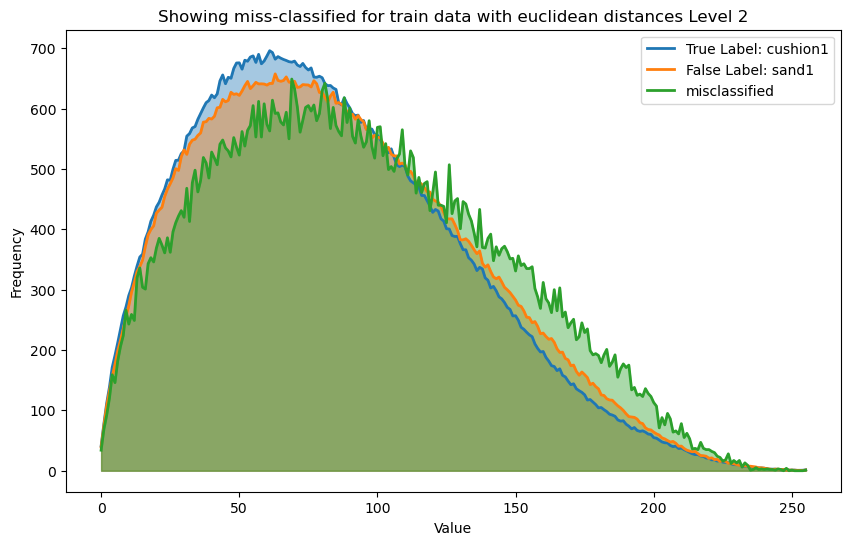

In [1414]:
plot_Miss_Classified_2(true_label_TE_2,false_label_TE_2,misclassified_image_TE_2,"Showing miss-classified for train data with euclidean distances Level 2")

In [1415]:
misclassified_indices_TC_2,misclassified_image_TC_2,true_label_TC_2,false_label_TC_2=miss_classified(train_data,predict_label_chi_train_2,"histogram_Level_2")

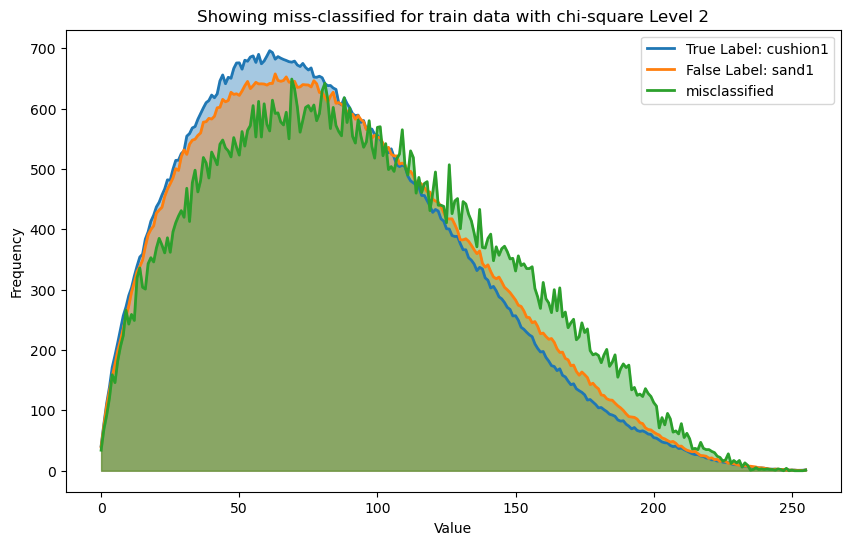

In [1416]:
plot_Miss_Classified_2(true_label_TC_2,false_label_TC_2,misclassified_image_TC_2,"Showing miss-classified for train data with chi-square Level 2")

In [1417]:
misclassified_indices_VE_2,misclassified_image_VE_2,true_label_VE_2,false_label_VE_2=miss_classified(val_data,predict_label_euclidena_val_2,"histogram_Level_2")

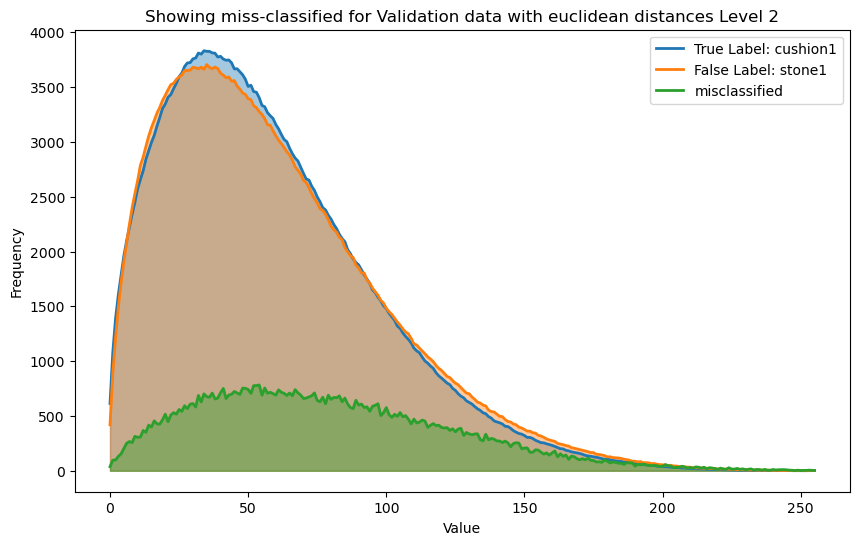

In [1418]:
plot_Miss_Classified(true_label_VE_2,false_label_VE_2,misclassified_image_VE_2,"Showing miss-classified for Validation data with euclidean distances Level 2")

In [1419]:
misclassified_indices_2,misclassified_image_2,true_label_2,false_label_2=miss_classified(val_data,predict_label_chi_val_2,"histogram_Level_2")

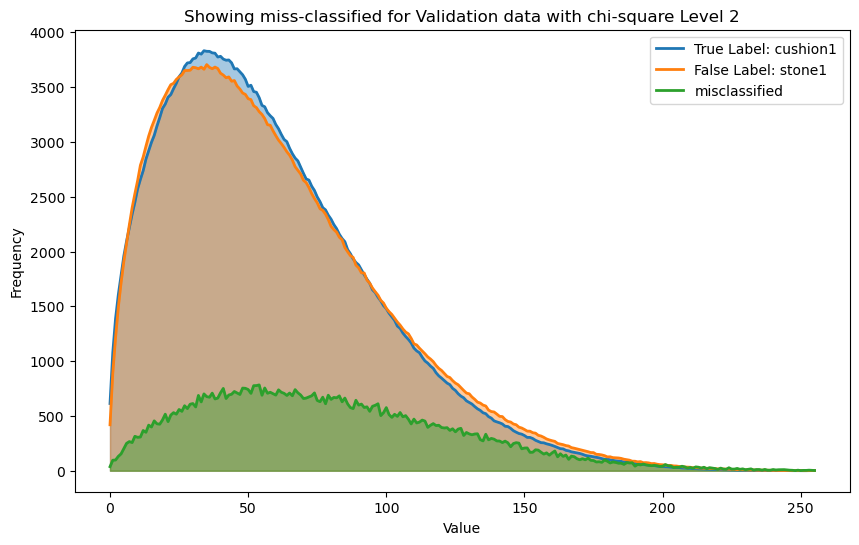

In [1420]:
plot_Miss_Classified(true_label_2,false_label_2,misclassified_image_2,"Showing miss-classified for Validation data with chi-square Level 2")

## The third level

In [1421]:
canvas1_df_3=split_By_cat("histogram_Level_3",train_data,"canvas1")
cushion1_df_3 = split_By_cat("histogram_Level_3", train_data, "cushion1")
linsseeds1_df_3 = split_By_cat("histogram_Level_3", train_data, "linsseeds1")
sand1_df_3 = split_By_cat("histogram_Level_3", train_data, "sand1")
seat2_df_3 = split_By_cat("histogram_Level_3", train_data, "seat2")
stone1_df_3 = split_By_cat("histogram_Level_3", train_data, "stone1")

In [1422]:
canvas1_df_avg_3=avg(canvas1_df_3)
cushion1_df_avg_3=avg(cushion1_df_3)
linsseeds1_df_avg_3=avg(linsseeds1_df_3)
sand1_df_avg_3=avg(sand1_df_3)
seat2_df_avg_3=avg(seat2_df_3)
stone1_df_avg_3=avg(stone1_df_3)

In [1423]:
concatenated_df_3 = pd.concat([canvas1_df_avg_3, cushion1_df_avg_3,linsseeds1_df_avg_3,sand1_df_avg_3,seat2_df_avg_3,stone1_df_avg_3], axis=1)

In [1424]:
column_names = ['canvas1', 'cushion1','linsseeds1','sand1','seat2','stone1']

# Assign the column names to the DataFrame
concatenated_df_3.columns = column_names

In [1425]:
concatenated_df_3

,canvas1,cushion1,linsseeds1,sand1,seat2,stone1
0,6.541667,4.250000,7.041667,6.041667,3.958333,7.291667
1,9.666667,5.041667,12.875000,9.666667,5.875000,12.250000
2,15.916667,7.958333,18.041667,12.416667,8.333333,15.958333
3,20.208333,10.000000,25.333333,17.000000,10.791667,20.875000
4,26.708333,11.916667,31.583333,20.791667,12.166667,27.208333
...,...,...,...,...,...,...
251,0.083333,0.958333,0.666667,0.458333,0.500000,0.541667
252,0.333333,0.625000,0.500000,0.458333,0.458333,0.333333
253,0.333333,0.666667,0.416667,0.375000,0.125000,0.291667
254,0.166667,0.458333,0.291667,0.291667,0.166667,0.250000


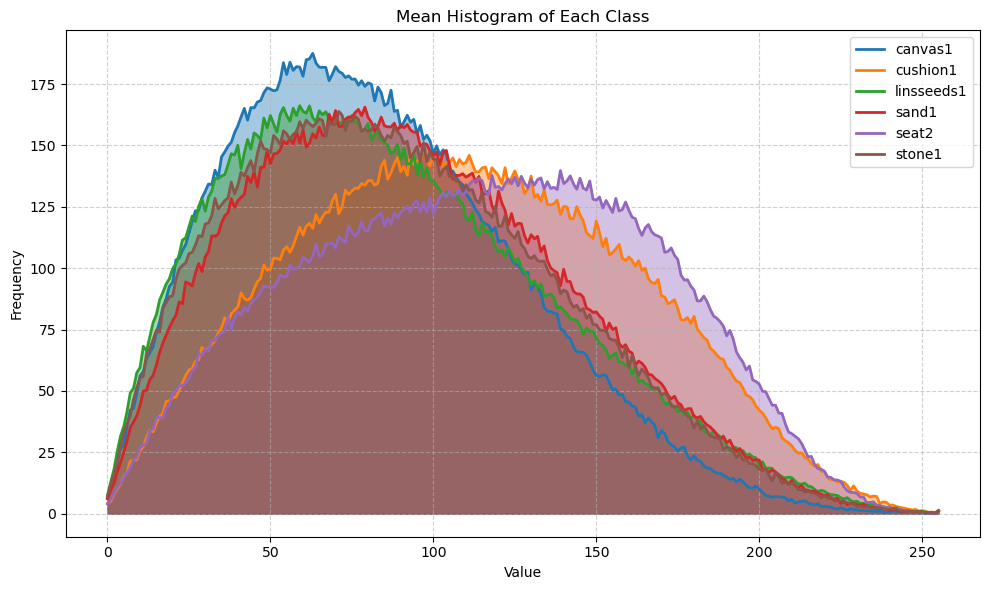

In [1426]:
data_level_3 = {'canvas1': canvas1_df_avg_3, 'cushion1': cushion1_df_avg_3, 'linsseeds1': linsseeds1_df_avg_3, 'sand1': sand1_df_avg_3, 'seat2': seat2_df_avg_3, 'stone1': stone1_df_avg_3}
Plot_Six_hist(data_level_3)

### work on Validation data Level 3

In [1427]:
class_histograms_3=[]
for col in concatenated_df_3.columns:
     class_histograms_3.append(concatenated_df_3[col].tolist())

In [1428]:
dict_data_3 = concatenated_df_3.to_dict(orient='list')

### Evaluatation on Validation (chi-square ,euclidean distances)    Level __3

In [1429]:
predict_label_euclidena_val_3=calculate_distance_each_image(val_data.histogram_Level_3,class_histograms_3,"euclidean")

In [1430]:
predict_label_chi_val_3=calculate_distance_each_image(val_data.histogram_Level_3,dict_data_3,"chi")

In [1431]:
accuracy_euclidena_val_3 = accuracy_score(val_data.Class, predict_label_euclidena_val_3)
recall_euclidena_3 = recall_score(val_data.Class, predict_label_euclidena_val_3, average='weighted')
precision_euclidena_3 = precision_score(val_data.Class, predict_label_euclidena_val_3, average='weighted')

print(f"Accuracy: {accuracy_euclidena_val_3:.2f}")
print(f"Recall: {recall_euclidena_3:.2f}")
print(f"Precision: {precision_euclidena_3:.2f}")

Accuracy: 0.89
Recall: 0.89
Precision: 0.92


In [1432]:
accuracy_chi_val_3 = accuracy_score(val_data.Class, predict_label_chi_val_3)
recall_chi_3 = recall_score(val_data.Class, predict_label_chi_val_3, average='weighted')
precision_chi_3 = precision_score(val_data.Class, predict_label_chi_val_3, average='weighted')

print(f"Accuracy: {accuracy_chi_val_3:.2f}")
print(f"Recall: {recall_chi_3:.2f}")
print(f"Precision: {precision_chi_3:.2f}")

Accuracy: 0.92
Recall: 0.92
Precision: 0.93


In [1433]:
accuracy_Valid_euclidena["Level_3"]=accuracy_euclidena_val_3
accuracy_Valid_Chi["Level_3"]=accuracy_chi_val_3

### Evaluatation on Train (chi-square ,euclidean distances)    Level __3

In [1434]:
predict_label_euclidena_train_3=calculate_distance_each_image(train_data.histogram_Level_3,class_histograms_3,"euclidean")

In [1435]:
predict_label_chi_train_3 = calculate_distance_each_image(train_data.histogram_Level_3, dict_data_3, "chi")

In [1436]:
accuracy_euclidena_train_3 = accuracy_score(train_data.Class, predict_label_euclidena_train_3)
recall_euclidena_3 = recall_score(train_data.Class, predict_label_euclidena_train_3, average='weighted')
precision_euclidena_3 = precision_score(train_data.Class, predict_label_euclidena_train_3, average='weighted')

print(f"Accuracy: {accuracy_euclidena_train_3:.2f}")
print(f"Recall: {recall_euclidena_3:.2f}")
print(f"Precision: {precision_euclidena_3:.2f}")

Accuracy: 0.88
Recall: 0.88
Precision: 0.88


In [1437]:
accuracy_chi_train_3 = accuracy_score(train_data.Class, predict_label_chi_train_3)
recall_chi_3 = recall_score(train_data.Class, predict_label_chi_train_3, average='weighted')
precision_chi_3 = precision_score(train_data.Class, predict_label_chi_train_3, average='weighted')

print(f"Accuracy: {accuracy_chi_train_3:.2f}")
print(f"Recall: {recall_chi_3:.2f}")
print(f"Precision: {precision_chi_3:.2f}")

Accuracy: 0.89
Recall: 0.89
Precision: 0.89


In [1438]:

accuracy_train_euclidena["Level_3"]=accuracy_euclidena_train_3
accuracy_Train_Chi["Level_3"]=accuracy_chi_train_3

### Evaluatation On Test (chi-square ,euclidean distances)    Level __3

In [1439]:
predict_label_euclidena_Test_3=calculate_distance_each_image(Test_Data.histogram_Level_3,class_histograms_3,"euclidean")

In [1440]:
predict_label_chi_test_3=calculate_distance_each_image(Test_Data.histogram_Level_3,dict_data_3,"chi")

In [1441]:
accuracy_euclidena_tset_3 = accuracy_score(Test_Data.Class, predict_label_euclidena_Test_3)
recall_euclidena_tset_3 = recall_score(Test_Data.Class, predict_label_euclidena_Test_3, average='weighted')
precision_euclidena_tset_3 = precision_score(Test_Data.Class, predict_label_euclidena_Test_3, average='weighted')

print(f"Accuracy: {accuracy_euclidena_tset_3:.2f}")
print(f"Recall: {recall_euclidena_tset_3:.2f}")
print(f"Precision: {precision_euclidena_tset_3:.2f}")

Accuracy: 0.88
Recall: 0.88
Precision: 0.89


In [1442]:
accuracy_chi_test_3 = accuracy_score(Test_Data.Class, predict_label_chi_test_3)
recall_chi_test_3 = recall_score(Test_Data.Class, predict_label_chi_test_3, average='weighted')
precision_chi_test_3 = precision_score(Test_Data.Class, predict_label_chi_test_3, average='weighted')

print(f"Accuracy: {accuracy_chi_test_3:.2f}")
print(f"Recall: {recall_chi_test_3:.2f}")
print(f"Precision: {precision_chi_test_3:.2f}")

Accuracy: 0.88
Recall: 0.88
Precision: 0.88


In [1443]:
accuracy_Test_euclidena["Level_3"]=accuracy_euclidena_tset_3
accuracy_Test_Chi["Level_3"]=accuracy_chi_test_3

### Check the miss-classified   Level  --3

In [1444]:

def plot_Miss_Classified_3(true_label,false_label,misclassified_image,title):
    data = {'canvas1': canvas1_df_avg_3, 'cushion1': cushion1_df_avg_3, 'linsseeds1': linsseeds1_df_avg_3, 'sand1': sand1_df_avg_3, 'seat2': seat2_df_avg_3, 'stone1': stone1_df_avg_3, 
            'misclassified': misclassified_image}

    # get the data of the true label and the false label
    data = {key: data[key] for key in [true_label, false_label, 'misclassified']}

    i = 0
    colors = plt.cm.tab10(np.arange(10))
    true_label_legend = f'True Label: {true_label}'
    false_label_legend = f'False Label: {false_label}'

    plt.figure(figsize=(10, 6))
    for label, series in data.items():
        if label == true_label:
            plt.plot(series, label=true_label_legend, color=colors[i], linewidth=2)
        elif label == false_label:
            plt.plot(series, label=false_label_legend, color=colors[i], linewidth=2)
        else:
            plt.plot(series, label=label, color=colors[i], linewidth=2)
        plt.fill_between(np.arange(256), series, alpha=0.4, color=colors[i])
        i += 1

    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f"{title}")
    plt.legend()
    plt.show()


In [1445]:
misclassified_indices_TE_3,misclassified_image_TE_3,true_label_TE_3,false_label_TE_3=miss_classified(train_data,predict_label_euclidena_train_3,"histogram_Level_3")

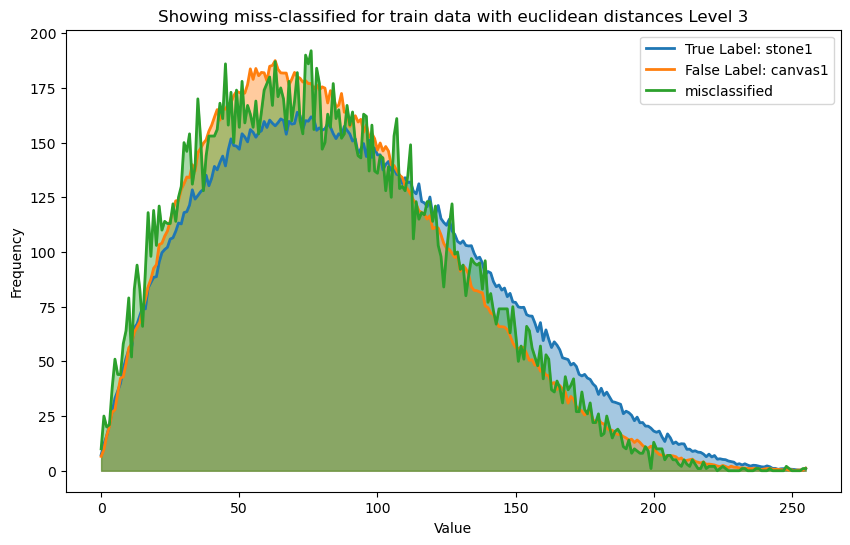

In [1446]:
plot_Miss_Classified_3(true_label_TE_3,false_label_TE_3,misclassified_image_TE_3,"Showing miss-classified for train data with euclidean distances Level 3")

In [1447]:
misclassified_indices_TC_3,misclassified_image_TC_3,true_label_TC_3,false_label_TC_3=miss_classified(train_data,predict_label_chi_train_3,"histogram_Level_3")

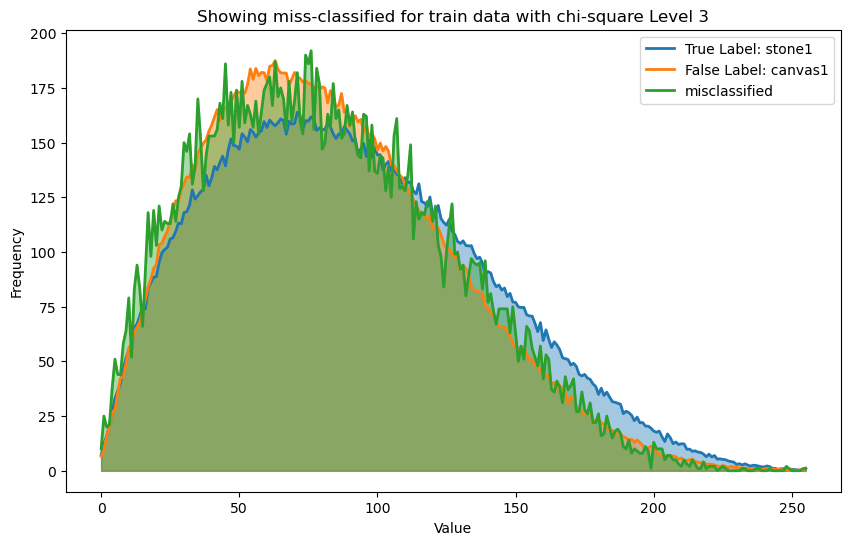

In [1448]:
plot_Miss_Classified_3(true_label_TC_3,false_label_TC_3,misclassified_image_TC_3,"Showing miss-classified for train data with chi-square Level 3")

In [1449]:
misclassified_indices_VE_3,misclassified_image_VE_3,true_label_VE_3,false_label_VE_3=miss_classified(val_data,predict_label_euclidena_val_3,"histogram_Level_3")

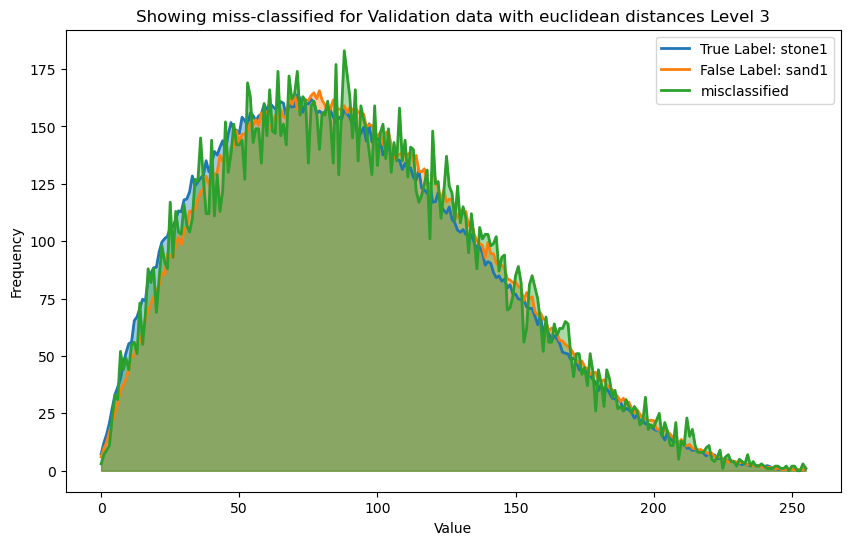

In [1450]:
plot_Miss_Classified_3(true_label_VE_3,false_label_VE_3,misclassified_image_VE_3,"Showing miss-classified for Validation data with euclidean distances Level 3")

In [1451]:
misclassified_indices_3,misclassified_image_3,true_label_3,false_label_3=miss_classified(val_data,predict_label_chi_val_3,"histogram_Level_3")

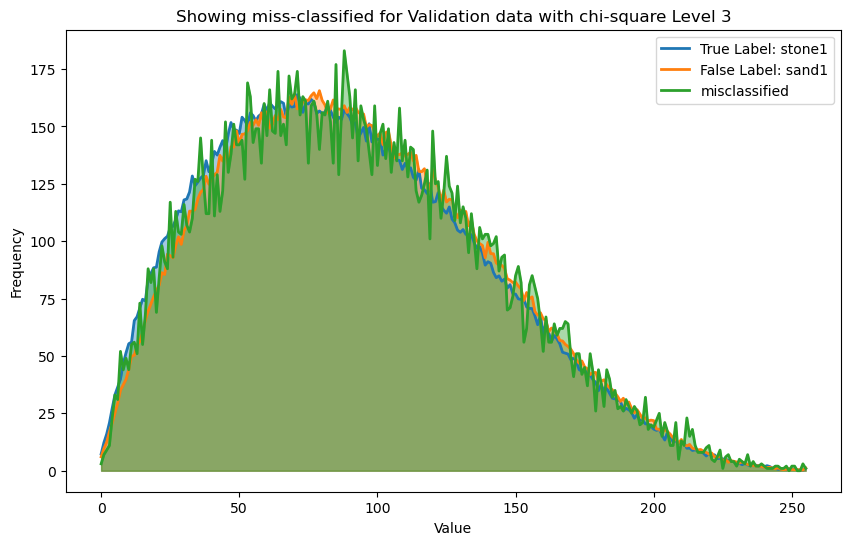

In [1452]:
plot_Miss_Classified_3(true_label_3,false_label_3,misclassified_image_3,"Showing miss-classified for Validation data with chi-square Level 3")

### Compare the Train and Validation and Test for the Three levels for Learning Free Classification  (Euclidena Distances , Chi Square Distances)

#### Create subplots for each accuracy type (train, valid, test) with the Three levels

In [1466]:
def plot_Accuracy_for_Different_Levels(accuracy_train,accuracy_Valid,accuracy_Test,Plot_title):

    level_names = list(accuracy_train.keys())
    train_values = [accuracy_train[level] for level in level_names]
    validation_values = [accuracy_Valid[level] for level in level_names]
    test_values = [accuracy_Test[level] for level in level_names]

    # Create subplots for each accuracy type (train, valid, test)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

   
    colors = ['skyblue', 'lightgreen', 'lightcoral']

    for i, data in enumerate([(train_values, 'Training Accuracy'), (validation_values, 'Validation Accuracy'), (test_values, 'Test Accuracy')]):
        ax = axs[i]
        values, title = data

        # Plot accuracy values
        bars = ax.bar(level_names, values, color=colors)
        ax.set_title(title)
        ax.set_ylim(0, 1)  # Adjust the y-axis limits if needed

       
        for bar, value in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2f}', ha='center', va='bottom')


    
    plt.suptitle(f'Training , Validation and Test Accuracy for Different Levels with  {Plot_title}')
    
    plt.tight_layout()
    plt.show()


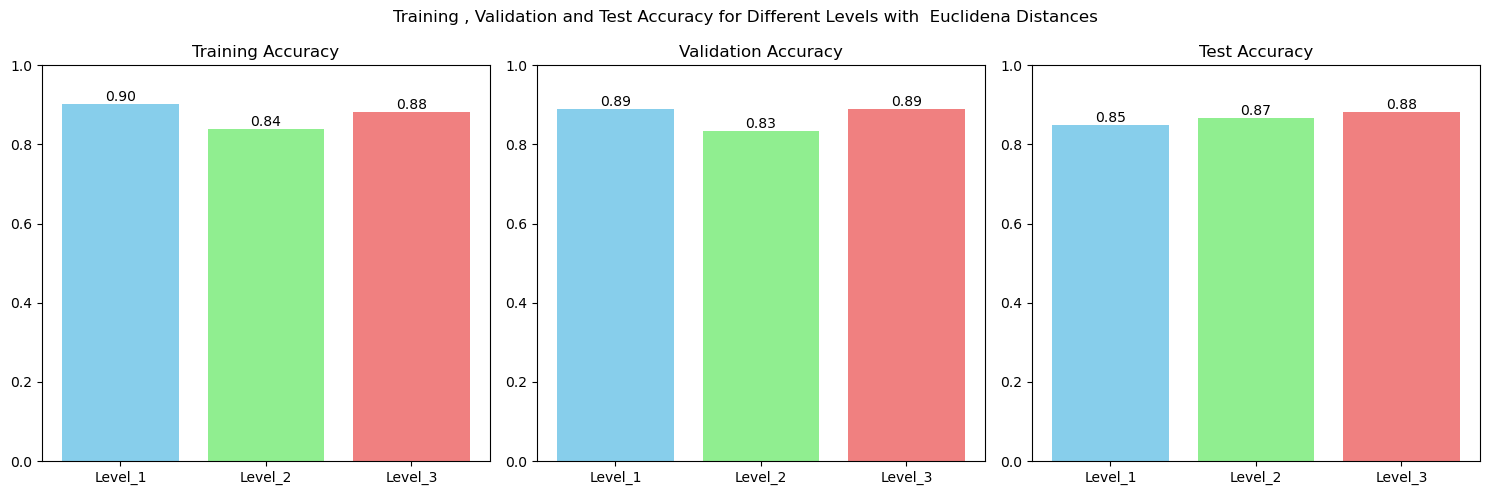

In [1467]:
plot_Accuracy_for_Different_Levels(accuracy_train_euclidena,accuracy_Valid_euclidena,accuracy_Test_euclidena,"Euclidena Distances")

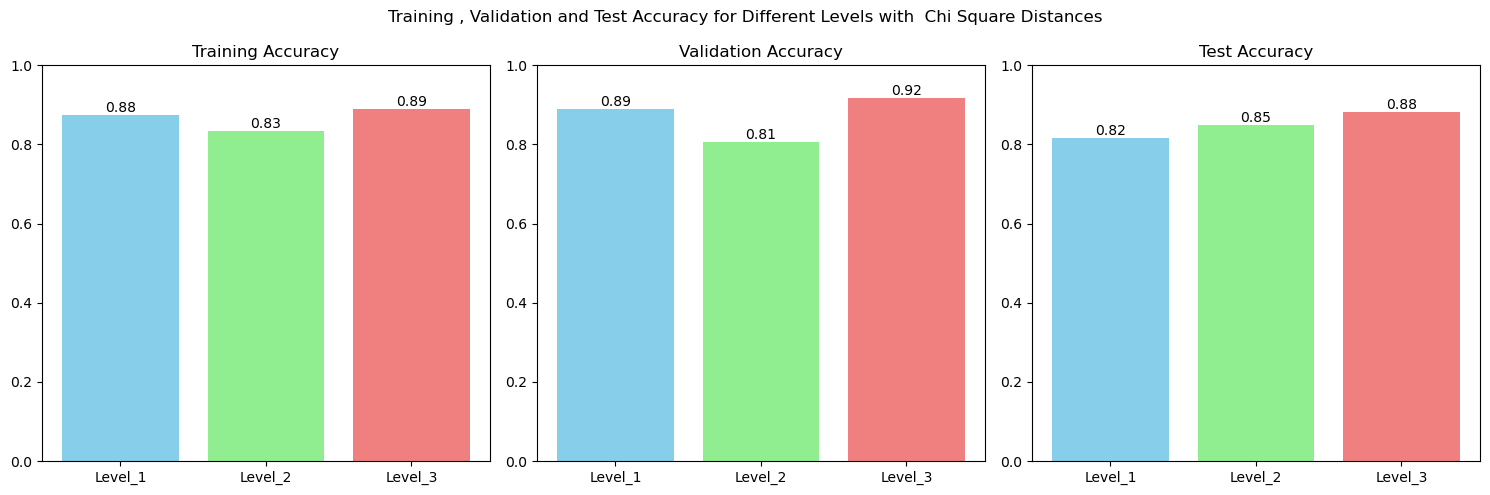

In [1468]:
plot_Accuracy_for_Different_Levels(accuracy_Train_Chi,accuracy_Valid_Chi,accuracy_Test_Chi,"Chi Square Distances")


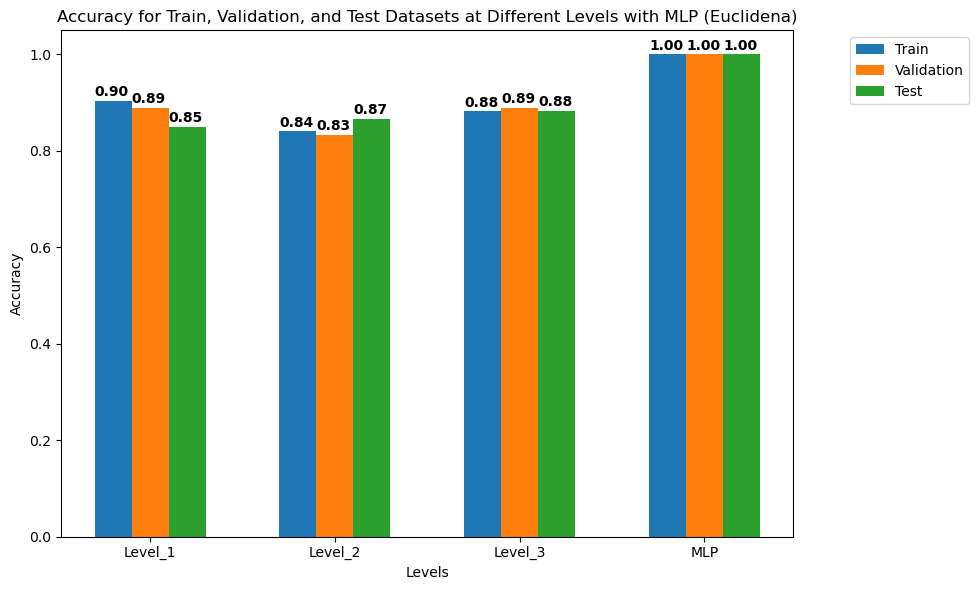

In [1465]:
accuracy_train_euclidena,accuracy_Valid_euclidena,accuracy_Test_euclidena

levels = list(accuracy_train_euclidena.keys())
train_values = [accuracy_train_euclidena[level] for level in levels]
validation_values = [accuracy_Valid_euclidena[level] for level in levels]
test_values = [accuracy_Test_euclidena[level] for level in levels]
levels.append("MLP")
train_values.append(train_accuracy_MLP)
validation_values.append(valid_accuracy_MLP)
test_values.append(test_accuracy_MLP)





plt.figure(figsize=(10, 6))  

width = 0.2
x = range(len(levels))

plt.bar(x, train_values, width, label='Train')
plt.bar([i + width for i in x], validation_values, width, label='Validation')
plt.bar([i + 2 * width for i in x], test_values, width, label='Test')

plt.xlabel('Levels')
plt.ylabel('Accuracy')
plt.title('Accuracy for Train, Validation, and Test Datasets at Different Levels with MLP (Euclidena)')
plt.xticks([i + width for i in x], levels)


for i, v in enumerate(train_values):
    plt.text(i - 0.1, v + 0.01, f'{v:.2f}', color='black', fontweight='bold')
for i, v in enumerate(validation_values):
    plt.text(i + width - 0.1, v + 0.01, f'{v:.2f}', color='black', fontweight='bold')
for i, v in enumerate(test_values):
    plt.text(i + 2 * width - 0.1, v + 0.01, f'{v:.2f}', color='black', fontweight='bold')


plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

plt.tight_layout()
plt.show()


## Discussion 

### We can see that the accuracy of the learning-free classification methods improved in the second and third levels but the third level has the best performance so the accuracy of the Euclidean distance becomed 88% instead of 85% in level 1 on test data and 87% in the second level and The accuracy of the Chi-Squared distance becomed 88% instead of 82% in level 1 on test data and 85% in the second level

### So by adding more levels will improve the accuracy of the learning-free classification because in the higher levels we focus on the good feature in the image